# Notebook 1: Corpus Construction from arXiv


## Purpose and Scope

This notebook defines and executes a reproducible pipeline to retrieve a scientific corpus from arXiv focused on the BiS₂ / BiCh₂ superconductors research domain. The resulting corpus constitutes the raw input for subsequent normalization, annotation, and ontology-driven analysis in this thesis.

The notebook is intentionally non-exploratory and contains only validated code required to:

- Define domain-specific search queries

- Query the arXiv API responsibly

- Extract and store structured metadata

In [ ]:
# Google Colab Environment Setup
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Environment Setup

To facilitate the research workflow, this section initializes the computational environment. The following command ensures the installation of all necessary Python libraries required for data acquisition (`arxiv`), data manipulation (`pandas`), and visualization (`matplotlib`, `seaborn`, `wordcloud`).

In [ ]:
# Install dependencies with the quiet flag to prevent excessive output logs
!pip install arxiv pandas matplotlib seaborn wordcloud python-dateutil tqdm --quiet

print("✅ Environment dependencies installed successfully.")

✅ Environment dependencies installed successfully.


## 2. Library Imports and System Configuration

This section imports the necessary Python modules for data acquisition, manipulation, and visualization. It also establishes global configuration settings for `matplotlib` and `seaborn` to ensure consistent aesthetic standards across all generated figures. Additionally, a timestamp is generated to version-control the execution of this notebook.

In [ ]:
# Standard Library Imports
import os
import json
import time
import re
from datetime import datetime
from collections import Counter
from pathlib import Path
from typing import List, Dict, Any, Union, Optional


try:
    from google.colab import drive
    from IPython.display import display, HTML
except ImportError:
    print("⚠️ Not running in Google Colab. Drive mounting skipped.")

# Data Acquisition and Analysis
import arxiv
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# --- Configuration ---

# Visualization Style Settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Execution Timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Output Verification
print("✅ Libraries imported and configuration applied successfully.")
print(f"🕒 Execution Timestamp: {timestamp}")

✅ Libraries imported and configuration applied successfully.
🕒 Execution Timestamp: 20260129_112944



## 3. Project Environment & Data Architecture

This notebook operates within a **strictly defined project environment** designed to ensure **reproducibility, traceability, and methodological clarity**. All assets are organized under a hierarchical folder structure hosted on **Google Drive**, enabling persistent storage and consistent access across sessions.

### 3.1. Project Directory Structure

All project components are centralized under the root `TFM/` directory. The structure enforces a clear separation between **code**, **data**, and **results**, facilitating maintenance, auditability, and peer review.
```markdown
```text
TFM/                             <- Root Directory
├── notebooks/                   <- Jupyter notebooks for experimentation
├── code/                        <- Modular Python scripts and utility functions
├── results/                     <- Final figures, tables, and reporting outputs
└── data/                        <- Data storage
    ├── raw/                     <- Original, immutable external datasets
    ├── processed/               <- Intermediate data transformations
    ├── output/                  <- Final model outputs
    └── corpora/                 <- TFM Corpus Processing Pipeline
        ├── 01_raw/              <- Stage 1: Ingestion (Original Documents)
        ├── 02_extracted/        <- Stage 2: Isolation (Extracted Text)
        ├── 03_normalized/       <- Stage 3: Standardization (Cleaned Text)
        └── 04_enriched/         <- Stage 4: Enrichment (Ontology-aligned)

```

### 3.2. Infrastructure & Design Principles

The project architecture follows explicit design principles:

* **Drive Integration:** The environment is directly integrated with Google Drive to ensure session continuity and compatibility with cloud-based workflows.
* **Separation of Concerns:** A strict boundary is maintained between **code** (`notebooks/`, `code/`) and **data** (`data/`, `results/`) to minimize the risk of accidental modification.
* **Reproducibility:** All notebooks assume deterministic input/output paths. An external researcher can reproduce the full workflow by executing the notebooks sequentially.

### 3.3. Methodology: Corpus Processing Pipeline

The `data/corpora/` directory implements a **linear Natural Language Processing (NLP) pipeline**. Data flows sequentially from Stage 01 to Stage 04:

1. **01 — Raw Data (Ingestion):** Immutable primary data (PDF/HTML) collected from scientific sources.
2. **02 — Extracted Text (Content Isolation):** Isolation of linguistic content from layout artifacts.
3. **03 — Normalized Text (Linguistic Standardization):** Noise reduction, Unicode normalization, and removal of non-semantic artifacts.
4. **04 — Enriched Corpus (Semantic Annotation):** Structurally enriched representations (ontology alignment) supporting Knowledge Representation tasks.

---



In [ ]:
# --- 1. Mount External Storage ---
if not os.path.exists('/content/drive'):
    print("🔌 Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("✅ Google Drive is already mounted.")

# --- 2. Configuration Parameters ---

# Base Root Path
BASE_PATH = Path("/content/drive/My Drive/TFM")

# High-Level Directory Schema
DIRECTORIES = {
    "notebooks": BASE_PATH / "notebooks",
    "code":      BASE_PATH / "code",
    "raw":       BASE_PATH / "data/raw",
    "processed": BASE_PATH / "data/processed",
    "output":    BASE_PATH / "data/output",
    "corpora":   BASE_PATH / "data/corpora",
    "results":   BASE_PATH / "results"
}

# Methodology-Specific Corpus Pipeline Stages
CORPUS_STAGES = [
    "01_raw",
    "02_extracted",
    "03_normalized",
    "04_enriched"
]

# --- 3. Directory Initialization ---

print(f"\n📂 Initializing Project Structure at: {BASE_PATH}\n")
print("-" * 60)

# A. Initialize High-Level Directories
for name, path in DIRECTORIES.items():
    try:
        path.mkdir(parents=True, exist_ok=True)
        print(f"  ✅ {name:<15} : {path}")
    except Exception as e:
        print(f"  ❌ {name:<15} : Error ({e})")

# B. Initialize Corpus Pipeline Sub-directories
print(f"\n🔄 Setting up Corpus Pipeline ({DIRECTORIES['corpora'].name})...")
for stage in CORPUS_STAGES:
    stage_path = DIRECTORIES['corpora'] / stage
    stage_path.mkdir(exist_ok=True)
    print(f"  🔹 {stage:<15} : {stage_path.name}")

# --- 4. Global Path Export ---
# Exposing paths as global constants for simplified access in downstream cells
NOTEBOOKS_PATH = DIRECTORIES["notebooks"]
CODE_PATH      = DIRECTORIES["code"]
RAW_PATH       = DIRECTORIES["raw"]
PROCESSED_PATH = DIRECTORIES["processed"]
OUTPUT_PATH    = DIRECTORIES["output"]
CORPORA_PATH   = DIRECTORIES["corpora"]
RESULTS_PATH   = DIRECTORIES["results"]

print("-" * 60)
print(f"✨ Setup complete. Root path locked to: {BASE_PATH}")

✅ Google Drive is already mounted.

📂 Initializing Project Structure at: /content/drive/My Drive/TFM

------------------------------------------------------------
  ✅ notebooks       : /content/drive/My Drive/TFM/notebooks
  ✅ code            : /content/drive/My Drive/TFM/code
  ✅ raw             : /content/drive/My Drive/TFM/data/raw
  ✅ processed       : /content/drive/My Drive/TFM/data/processed
  ✅ output          : /content/drive/My Drive/TFM/data/output
  ✅ corpora         : /content/drive/My Drive/TFM/data/corpora
  ✅ results         : /content/drive/My Drive/TFM/results

🔄 Setting up Corpus Pipeline (corpora)...
  🔹 01_raw          : 01_raw
  🔹 02_extracted    : 02_extracted
  🔹 03_normalized   : 03_normalized
  🔹 04_enriched     : 04_enriched
------------------------------------------------------------
✨ Setup complete. Root path locked to: /content/drive/My Drive/TFM


## 4. Version Control & Repository Synchronization

To ensure code consistency and facilitate version control, this notebook synchronizes with the central GitHub repository. This step ensures that the runtime environment utilizes the most recent version of the codebase, particularly for shared utility modules located in the `code/` directory.

The system utilizes a secure token stored in Colab's `userdata` to authenticate with the repository without exposing credentials in the notebook source.

In [ ]:
#SECTION MOVED TO AN EXTERNAL NOTEBOOK

## 5. Data Acquisition Strategy: The arXiv API Interface

### 5.1. Context: The arXiv Repository
arXiv is an open-access archive for scholarly articles in physics, mathematics, computer science, and quantitative biology. Hosting over two million preprints, it serves as a critical primary source for text mining in **Materials Physics**, offering immediate access to the latest research prior to formal journal publication. Its open API allows for the systematic retrieval of metadata and full-text documents, making it an ideal substrate for corpus construction.

### 5.2. The `arxiv` Python Wrapper
This project utilizes the `arxiv` Python library to programmatically interface with the repository. This wrapper encapsulates the public API, managing request limits, pagination, and error handling. The architecture relies on three core components:

* `arxiv.Search()`: Defines the query parameters, including search strings, filters, sorting logic, and retrieval limits.
* `arxiv.Client()`: Manages the network transport and execution strategy, ensuring compliance with API rate limits (e.g., specific delays between requests).
* `Result`: A structured object returned by the client representing a single paper. It contains standardized metadata fields such as authors, abstracts, DOIs, and primary categories.

### 5.3. Search Object Configuration
To ensure the relevance and reproducibility of the data collection, the search client is initialized with deterministic parameters. The standard configuration pattern used in this workflow is:

```python
search = arxiv.Search(
    query = "your_query_string",               # The strict search query
    max_results = 100,                         # Limit retrieval to control corpus size
    sort_by = arxiv.SortCriterion.SubmittedDate, # Order by submission date
    sort_order = arxiv.SortOrder.Descending      # Newest articles first
)

```









### 5.4. Query Syntax and Field Prefixes

The API supports advanced filtering through specific field prefixes. These allow the search scope to be restricted to specific metadata fields, significantly increasing the precision of the retrieval process.

| Prefix | Targeted Field | Example Usage | Description |
| --- | --- | --- | --- |
| `ti:` | **Title** | `ti:superconductor` | Matches terms only within the article title. |
| `au:` | **Author** | `au:Mizuguchi` | Matches specific author names. |
| `abs:` | **Abstract** | `abs:BiS2` | Searches for terms within the abstract text. |
| `all:` | **All Fields** | `all:LaOBiS2` | Searches title, abstract, and authors. |
| `cat:` | **Category** | `cat:cond-mat.supr-con` | Restricts results to specific arXiv sub-categories. |

**Boolean Logic:** Terms can be combined using standard boolean operators: `AND`, `OR`, and `ANDNOT` (e.g., `ti:superconductor AND cat:cond-mat.mtrl-sci`).



### 5.5. Client Initialization and Rate Limiting

To maintain stability and respect the `arXiv` API's terms of service, a dedicated client instance is configured with specific rate-limiting parameters. The `configure_arxiv_client` function instantiates the client with a defined page size and delay strategy. This ensures that large data retrieval tasks (fetching thousands of metadata records) do not trigger server-side blocking or connection timeouts.

In [ ]:
def configure_arxiv_client(
    page_size: int = 100,
    delay_seconds: float = 3.0,
    num_retries: int = 5
) -> arxiv.Client:
    """
    Initializes and configures the ArXiv API client with deterministic rate limits.

    This configuration ensures robust data retrieval by handling pagination automatically
    and inserting delays between requests to prevent API throttling.

    Args:
        page_size (int): Number of results to fetch per pagination batch. Default is 100.
        delay_seconds (float): Pause duration between requests to respect API limits. Default is 3.0s.
        num_retries (int): Maximum retry attempts for failed HTTP requests. Default is 5.

    Returns:
        arxiv.Client: A configured instance ready for query execution.
    """

    # Initialize the client with the defined configuration
    client = arxiv.Client(
        page_size=page_size,
        delay_seconds=delay_seconds,
        num_retries=num_retries
    )

    # Verification Output
    print("✅ ArXiv Client Successfully Configured")
    print(f"   • Page Size:       {client.page_size} records")
    print(f"   • Request Delay:   {client.delay_seconds}s")
    print(f"   • Max Retries:     {client.num_retries}")

    return client

# --- Execution ---
# Initialize the global client instance for use in subsequent queries
client = configure_arxiv_client()

✅ ArXiv Client Successfully Configured
   • Page Size:       100 records
   • Request Delay:   3.0s
   • Max Retries:     5


### 5.6. Data Extraction and Standardization Logic

The raw objects returned by the `arxiv` API contain nested structures that are not immediately suitable for tabular analysis. To address this, a dedicated extraction pipeline is implemented to serialize these objects into flat dictionaries.

Two primary functions are defined:
1.  `extract_paper_data(result)`: Acts as a **serialization layer**, mapping specific attributes from the API response (e.g., `result.summary`, `result.published`) to a standardized schema. It performs initial cleaning, such as formatting dates to ISO standards and flattening author lists.
2.  `search_arxiv(query, ...)`: Acts as the **execution layer**. It utilizes the configured client to perform the query, handles pagination via the `tqdm` progress bar, and manages potential network exceptions during the retrieval process.

In [ ]:
def extract_paper_data(result):
    """
    Extracts relevant data from an arXiv result.

    Parameters:
    -----------
    result : arxiv.Result
        Result object from the arXiv API.

    Returns:
    --------
    dict : Dictionary containing paper metadata.
    """
    return {
        # Identifiers
        'arxiv_id': result.entry_id.split('/')[-1],  # Short ID (e.g., 2301.12345)
        'entry_id': result.entry_id,                 # Full URL
        'doi': result.doi,

        # Basic Metadata
        'title': result.title,
        'abstract': result.summary,
        'authors': [author.name for author in result.authors],
        'authors_str': ', '.join([author.name for author in result.authors]),

        # Dates
        'published': result.published.isoformat() if result.published else None,
        'updated': result.updated.isoformat() if result.updated else None,
        'year': result.published.year if result.published else None,

        # Categorization
        'primary_category': result.primary_category,
        'categories': result.categories,

        # Links
        'pdf_url': result.pdf_url,
        'comment': result.comment,
        'journal_ref': result.journal_ref,
    }


def search_arxiv(query, max_results=200, sort_by=arxiv.SortCriterion.SubmittedDate):
    """
    Performs a search on arXiv and returns results as a list of dictionaries.

    Parameters:
    -----------
    query : str
        Search query in arXiv format.
    max_results : int
        Maximum number of results to fetch.
    sort_by : arxiv.SortCriterion
        Sorting criterion.

    Returns:
    --------
    list : List of dictionaries containing paper data.
    """
    search = arxiv.Search(
        query=query,
        max_results=max_results,
        sort_by=sort_by,
        sort_order=arxiv.SortOrder.Descending
    )

    results = []

    try:
        for result in tqdm(client.results(search), total=max_results, desc="Downloading"):
            paper_data = extract_paper_data(result)
            results.append(paper_data)
    except Exception as e:
        print(f"⚠️ Error during search: {e}")
        print(f"   Retrieved {len(results)} results before the error.")

    return results


print("✅ Search functions defined")

✅ Search functions defined


### 5.7. Batch Execution and Corpus Aggregation Strategy

To construct a representative corpus, the retrieval process is designed to execute multiple independent search queries sequentially. This approach allows for the targeted collection of documents across distinct sub-domains of Materials Physics.

A critical component of this stage is **deduplication**. Since a single paper may appear in the results of multiple overlapping queries (e.g., a paper on "superconducting thin films" might appear in both "Superconductivity" and "Thin Film" searches), the `execute_multiple_searches` function implements a set-based aggregation logic using the unique `arxiv_id` as the primary key. This ensures that the final dataset contains unique records, preserving statistical validity.

In [ ]:
from typing import List, Tuple, Dict, Any

def execute_multiple_searches(
    queries: List[Tuple[str, str]],
    max_per_query: int = 200
) -> Tuple[List[Dict[str, Any]], Dict[str, Dict[str, int]]]:
    """
    Executes a batch of search queries and aggregates unique results.

    This function iterates through a defined list of search tuples, retrieves data
    using the global `client`, and merges results into a single collection. It
    automatically handles deduplication, ensuring that papers matching multiple
    queries are only stored once.

    Args:
        queries (List[Tuple[str, str]]): A list of tuples, where each tuple contains
            a descriptive name and the query string (e.g., [("Topic A", "cat:x")]).
        max_per_query (int): The maximum number of records to retrieve per query.

    Returns:
        Tuple:
            - List[Dict]: A list of unique paper dictionaries.
            - Dict[str, Dict]: Statistics for each query (found, new, duplicates).
    """
    all_papers = {}  # Acts as a hash map for deduplication (Key: arxiv_id)
    stats = {}

    for name, query in queries:
        print(f"\n{'='*60}")
        print(f"🔍 Executing Search Module: {name}")
        # Truncate long query strings for cleaner log output
        display_query = f"{query[:80]}..." if len(query) > 80 else query
        print(f"   Query: {display_query}")
        print(f"{'='*60}")

        # Execute single search
        results = search_arxiv(query, max_results=max_per_query)

        # Deduplication Logic
        new_count = 0
        for paper in results:
            arxiv_id = paper['arxiv_id']
            if arxiv_id not in all_papers:
                all_papers[arxiv_id] = paper
                new_count += 1
            # If arxiv_id is in all_papers, it is a duplicate and we skip it

        # Record Statistics
        stats[name] = {
            'total_retrieved': len(results),
            'unique_added': new_count,
            'duplicates_ignored': len(results) - new_count
        }

        print(f"\n📊 Module Stats: {len(results)} retrieved | {new_count} new | {len(results) - new_count} duplicates")

        # Rate Limiting: Pause between distinct queries to be a "good citizen"
        time.sleep(2)

    return list(all_papers.values()), stats

print("✅ Batch execution and aggregation logic defined.")

✅ Batch execution and aggregation logic defined.


## 6. Domain-Specific Query Formulation: The BiS₂ / BiCh₂ Family

### 6.1. Identification of Key Search Terms
To effectively capture the relevant literature, the search strategy targets the specific nomenclature of the **BiS₂-based superconducting family**.



The query construction relies on the intersection of three distinct semantic categories:

1.  **Chemical Formulas:** Explicit targeting of the active superconducting layers (e.g., $\text{BiS}_2$, $\text{BiSe}_2$) and the spacer/blocking layers (e.g., $\text{LaOBiS}_2$, $\text{CeOBiS}_2$, $\text{NdOBiS}_2$). This includes specific doped variants such as $\text{LaO}_{1-x}\text{F}_x\text{BiS}_2$.
2.  **Descriptive Terminology:** Natural language phrases commonly used in abstracts, such as *"BiS2-based superconductor"* or *"BiCh2 layered compound."*
3.  **Subject Categories:** Restriction to relevant arXiv categories (`cond-mat.supr-con`, `cond-mat.mtrl-sci`, `cond-mat.str-el`) to filter out homonyms from unrelated fields.





### 6.2. Modular Search Strategy
Instead of utilizing a single monolithic query, this workflow defines a **granular set of specific search strings**. This modular approach ensures robust coverage by independently targeting:
* General family descriptors (BiS2, BiCh2).
* Specific chemical compositions (e.g., Rare Earths, Sr/Eu compounds).
* Descriptive metadata matches.

### 6.3. Query Definitions (Version 1.0)

The following block implements the granular search strategy defined above. The queries are versioned (`v1.0`) to track the evolution of the search scope throughout the research project.

The queries satisfy the following specific objectives:
1.  **General vs. Specific:** Captures both broad terms (`BiS2_general`) and specific stoichiometry (`REOBiS2_series`).
2.  **Chemical Variants:** Explicitly includes the parent compound ($\text{Bi}_4\text{O}_4\text{S}_3$) and Fluorine-doped variants ($\text{SrFBiS}_2$).
3.  **Linguistic Variations:** Accounts for hyphenated descriptors (e.g., *"BiS2-based"*) often found in titles.uery v1

In [ ]:
# --- Configuration Constants ---
MAX_RESULTS_PER_QUERY = 200
QUERY_VERSION = "v1.0"

def build_focused_queries_1() -> List[Tuple[str, str]]:
    """
    Constructs the version 1.0 list of search queries for the BiS2 dataset.

    This modular list strategy prevents single-query character limits and allows
    for granular error tracking per sub-topic.

    Returns:
        List[Tuple[str, str]]: A list of (query_name, query_string) tuples.
    """
    queries = []

    # 1. Broad Category Search
    # Targets the intersection of the chemical signature and the phenomenon
    queries.append((
        "BiS2_general",
        'all:BiS2 AND all:superconductor'
    ))

    # 2. Extended Family (Chalcogenides)
    # Catches variations using the broader 'BiCh2' notation
    queries.append((
        "BiCh2_general",
        'all:BiCh2'
    ))

    # 3. Rare-Earth Series (REOBiS2)
    # Explicitly targets the Lanthanide series compounds
    queries.append((
        "REOBiS2_series",
        'all:LaOBiS2 OR all:CeOBiS2 OR all:NdOBiS2 OR all:PrOBiS2'
    ))

    # 4. Parent Compound
    # The first discovered superconductor in this family
    queries.append((
        "Bi4O4S3",
        'all:Bi4O4S3'
    ))

    # 5. Fluorine-Doped Variants (Sr/Eu)
    # Targets specific doping structures often cited in experimental papers
    queries.append((
        "SrEu_compounds",
        'all:SrFBiS2 OR all:EuFBiS2 OR all:EuBiS2F'
    ))

    # 6. Metadata/Descriptive Search
    # Targets hyphenated terms in titles (ti) and abstracts (abs)
    queries.append((
        "descriptive",
        'ti:"BiS2-based" OR abs:"BiS2-based" OR ti:"BiCh2-based" OR abs:"BiCh2-based"'
    ))

    # 7. Semantic Intersection
    # A broad net for papers describing the material class without specific formulas
    queries.append((
        "bismuth_chalcogenide",
        'all:bismuth AND all:chalcogenide AND all:superconductor'
    ))

    return queries

# --- Verification ---
focused_queries_1 = build_focused_queries_1()

print(f"📋 Query Strategy {QUERY_VERSION} Initialized")
print("="*80)
for name, query in focused_queries_1:
    print(f"\n🔹 {name:<20} : {query}")

📋 Query Strategy v1.0 Initialized

🔹 BiS2_general         : all:BiS2 AND all:superconductor

🔹 BiCh2_general        : all:BiCh2

🔹 REOBiS2_series       : all:LaOBiS2 OR all:CeOBiS2 OR all:NdOBiS2 OR all:PrOBiS2

🔹 Bi4O4S3              : all:Bi4O4S3

🔹 SrEu_compounds       : all:SrFBiS2 OR all:EuFBiS2 OR all:EuBiS2F

🔹 descriptive          : ti:"BiS2-based" OR abs:"BiS2-based" OR ti:"BiCh2-based" OR abs:"BiCh2-based"

🔹 bismuth_chalcogenide : all:bismuth AND all:chalcogenide AND all:superconductor


### 6.4. Pipeline Execution Logic

The `run_corpus_search` function serves as the high-level orchestrator for the data acquisition process. It wraps the batch execution logic defined in Section 5.7, providing user feedback and global status monitoring.

This function ensures that the execution flow is transparent, logging the start and completion of the retrieval process, which is critical when processing large queries against external APIs.

In [ ]:
def run_corpus_search(
    queries: List[Tuple[str, str]],
    query_version: str,
    max_results: int = 200
) -> Tuple[List[Dict[str, Any]], Dict[str, Dict[str, int]]]:
    """
    Orchestrates the execution of the search pipeline for a specific query version.

    This function acts as a wrapper around 'execute_multiple_searches', adding
    logging and user feedback layers suitable for long-running processes.

    Args:
        queries (List[Tuple[str, str]]): The list of query definitions to execute.
        query_version (str): Identifier for the query set (e.g., "v1.0").
        max_results (int): Hard limit on results per individual query.

    Returns:
        Tuple:
            - List[Dict]: The aggregated list of unique paper dictionaries.
            - Dict[str, Dict]: Statistical breakdown of the search results.
    """
    header_title = f"QUERY EXECUTION: {query_version}"
    print(f"\n{'-'*80}")
    print(f"{header_title:^80}")
    print(f"{'-'*80}\n")

    print("🚀 Starting arXiv retrieval pipeline...")
    print(f"   • Configuration: Max {max_results} results per query module.")
    print("   • Status: Processing... (This may take several minutes)\n")

    # Execute the batch search using the aggregation logic from Section 5.7
    papers, search_stats = execute_multiple_searches(queries, max_per_query=max_results)

    print(f"\n{'='*80}")
    print(f"✅ SEARCH COMPLETED SUCCESSFULLY")
    print(f"{'='*80}")
    print(f"📚 Total unique documents collected: {len(papers)}")

    return papers, search_stats

print("✅ Pipeline execution logic defined.")

✅ Pipeline execution logic defined.


### 6.5. Execution of Search Strategy (v1.0)

This cell initiates the retrieval pipeline defined in the previous sections. It executes the `focused_queries_1` list against the arXiv API.

**Note on Performance:**
Due to the enforced rate-limiting (3-second delay between requests) and the sequential processing of multiple query modules, this cell may take several minutes to complete. Progress is visualized via the console output.

In [ ]:
# --- Pipeline Execution ---

# Execute the search strategy using the version 1.0 configuration
# The results are stored in 'papers_v1' to maintain version traceability
papers_v1, search_stats_v1 = run_corpus_search(
    queries=focused_queries_1,
    query_version=QUERY_VERSION,
    max_results=MAX_RESULTS_PER_QUERY
)

# Optional: Quick verification of the output type
print(f"Data verification: {type(papers_v1)} containing {len(papers_v1)} records.")


--------------------------------------------------------------------------------
                             QUERY EXECUTION: v1.0                              
--------------------------------------------------------------------------------

🚀 Starting arXiv retrieval pipeline...
   • Configuration: Max 200 results per query module.
   • Status: Processing... (This may take several minutes)


🔍 Executing Search Module: BiS2_general
   Query: all:BiS2 AND all:superconductor


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]


📊 Module Stats: 69 retrieved | 69 new | 0 duplicates

🔍 Executing Search Module: BiCh2_general
   Query: all:BiCh2


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]


📊 Module Stats: 19 retrieved | 17 new | 2 duplicates

🔍 Executing Search Module: REOBiS2_series
   Query: all:LaOBiS2 OR all:CeOBiS2 OR all:NdOBiS2 OR all:PrOBiS2


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]


📊 Module Stats: 30 retrieved | 23 new | 7 duplicates

🔍 Executing Search Module: Bi4O4S3
   Query: all:Bi4O4S3


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]


📊 Module Stats: 21 retrieved | 6 new | 15 duplicates

🔍 Executing Search Module: SrEu_compounds
   Query: all:SrFBiS2 OR all:EuFBiS2 OR all:EuBiS2F


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]


📊 Module Stats: 9 retrieved | 4 new | 5 duplicates

🔍 Executing Search Module: descriptive
   Query: ti:"BiS2-based" OR abs:"BiS2-based" OR ti:"BiCh2-based" OR abs:"BiCh2-based"


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]


📊 Module Stats: 79 retrieved | 0 new | 79 duplicates

🔍 Executing Search Module: bismuth_chalcogenide
   Query: all:bismuth AND all:chalcogenide AND all:superconductor


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]


📊 Module Stats: 4 retrieved | 2 new | 2 duplicates

✅ SEARCH COMPLETED SUCCESSFULLY
📚 Total unique documents collected: 121
Data verification: <class 'list'> containing 121 records.


### 6.6. Search Strategy Performance Analysis

To evaluate the efficacy of the modular search strategy, the retrieval statistics are aggregated into a structured DataFrame. This analysis quantifies the yield of each query module, distinguishing between unique contributions and redundant overlaps.

This step is essential for **iterative query refinement**:
* **High Overlap:** Indicates that a specific query may be a subset of another (e.g., "BiS2" capturing all "BiCh2" results).
* **Low Yield:** Suggests a query may be too restrictive or the terminology is uncommon in the target domain.

In [ ]:
def create_query_stats_df(
    search_stats: Dict[str, Dict[str, int]],
    queries: List[Tuple[str, str]]
) -> pd.DataFrame:
    """
    Transforms raw search statistics into a Pandas DataFrame for comparative analysis.

    Args:
        search_stats (Dict): The dictionary returned by 'execute_multiple_searches'
                             containing 'total_retrieved', 'unique_added', etc.
        queries (List[Tuple]): The original list of (name, query_string) tuples.

    Returns:
        pd.DataFrame: A summary table of retrieval performance per query module.
    """

    # 1. Create a high-speed lookup map for query strings
    # Mapping: query_name -> query_string
    query_text_map = {name: text for name, text in queries}

    data = []

    # 2. Iterate through statistics and construct rows
    for name, stats in search_stats.items():
        row = {
            'query_name': name,
            'query_text': query_text_map.get(name, "Unknown"), # Fallback safety
            # Note: Keys must match those defined in Section 5.7
            'articles_found': stats['total_retrieved'],
            'new_articles': stats['unique_added'],
            'duplicated_articles': stats['duplicates_ignored']
        }
        data.append(row)

    # 3. Construct DataFrame
    df = pd.DataFrame(data)

    # 4. Add a 'Uniqueness Ratio' column for deeper insight
    # (Avoid division by zero)
    df['uniqueness_ratio'] = df.apply(
        lambda x: round(x['new_articles'] / x['articles_found'], 2) if x['articles_found'] > 0 else 0,
        axis=1
    )

    print("📊 Query Statistics Summary:")
    print("-" * 30)
    display(df)

    return df

# --- Execution ---
# Generate statistics for the v1.0 search
df_stats_v1 = create_query_stats_df(search_stats_v1, focused_queries_1)

📊 Query Statistics Summary:
------------------------------


,query_name,query_text,articles_found,new_articles,duplicated_articles,uniqueness_ratio
0,BiS2_general,all:BiS2 AND all:superconductor,69,69,0,1.00
1,BiCh2_general,all:BiCh2,19,17,2,0.89
2,REOBiS2_series,all:LaOBiS2 OR all:CeOBiS2 OR all:NdOBiS2 OR a...,30,23,7,0.77
3,Bi4O4S3,all:Bi4O4S3,21,6,15,0.29
4,SrEu_compounds,all:SrFBiS2 OR all:EuFBiS2 OR all:EuBiS2F,9,4,5,0.44
5,descriptive,"ti:""BiS2-based"" OR abs:""BiS2-based"" OR ti:""BiC...",79,0,79,0.00
6,bismuth_chalcogenide,all:bismuth AND all:chalcogenide AND all:super...,4,2,2,0.50


### 6.7. Quantitative Evaluation of Search Strategy

The following code generates a statistical summary of the retrieval process. By converting the raw execution logs into a DataFrame, we can inspect the `uniqueness_ratio` (defined in the previous function) to determine the efficiency of each query module.

* **High Uniqueness:** Indicates a highly specific query that retrieved documents not found by other modules.
* **High Duplication:** Indicates significant semantic overlap with previous modules.

In [ ]:
# --- Statistical Analysis ---

# Generate the summary DataFrame using the statistics from the execution phase
query_stats_df = create_query_stats_df(
    search_stats=search_stats_v1,    # Using the variable from Section 6.5
    queries=focused_queries_1
)

# Optional: Inspect the top performing queries by new articles found
print("\n🏆 Top Contributing Queries:")
display(query_stats_df.sort_values(by='new_articles', ascending=False).head(3))

📊 Query Statistics Summary:
------------------------------


,query_name,query_text,articles_found,new_articles,duplicated_articles,uniqueness_ratio
0,BiS2_general,all:BiS2 AND all:superconductor,69,69,0,1.00
1,BiCh2_general,all:BiCh2,19,17,2,0.89
2,REOBiS2_series,all:LaOBiS2 OR all:CeOBiS2 OR all:NdOBiS2 OR a...,30,23,7,0.77
3,Bi4O4S3,all:Bi4O4S3,21,6,15,0.29
4,SrEu_compounds,all:SrFBiS2 OR all:EuFBiS2 OR all:EuBiS2F,9,4,5,0.44
5,descriptive,"ti:""BiS2-based"" OR abs:""BiS2-based"" OR ti:""BiC...",79,0,79,0.00
6,bismuth_chalcogenide,all:bismuth AND all:chalcogenide AND all:super...,4,2,2,0.50



🏆 Top Contributing Queries:


,query_name,query_text,articles_found,new_articles,duplicated_articles,uniqueness_ratio
0,BiS2_general,all:BiS2 AND all:superconductor,69,69,0,1.00
2,REOBiS2_series,all:LaOBiS2 OR all:CeOBiS2 OR all:NdOBiS2 OR a...,30,23,7,0.77
1,BiCh2_general,all:BiCh2,19,17,2,0.89


In [ ]:
# Query Performance Visualization

def plot_query_performance(df, query_version):
    """
    Plots a grouped bar chart comparing new vs. duplicated articles per query.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing 'query_name', 'new_articles', and 'duplicated_articles'.
    query_version : str
        Version identifier for the query.
    Returns:
    --------
    None
    """
    # Setup plot dimensions
    fig, ax = plt.subplots(figsize=(12, 6))

    x = range(len(df))
    width = 0.35

    # Create bars
    # Note: 'query_name' is the standard column name from our previous function
    bars1 = ax.bar([i - width/2 for i in x], df['new_articles'], width, label='New', color='steelblue')
    bars2 = ax.bar([i + width/2 for i in x], df['duplicated_articles'], width, label='Duplicated', color='lightcoral')

    # Formatting
    ax.set_xlabel('Query Name')
    ax.set_ylabel('Number of Articles')
    ax.set_title(f'Search Results Distribution for query {query_version}: New vs. Duplicates')
    ax.set_xticks(x)
    ax.set_xticklabels(df['query_name'], rotation=45, ha='right')
    ax.legend()

    # Add value labels on top of bars for clarity
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.annotate(f'{height}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()



### 6.8. Visualization of Retrieval Efficiency

To visually assess the marginal gain of each search query, a grouped bar chart is generated. This visualization highlights the ratio of **new information** (unique records) versus **redundant information** (duplicates) for each search module.

* **Blue Bars (New):** Represent the unique contribution of the query to the corpus.
* **Red Bars (Duplicated):** Represent the overlap with previous queries.

This visual feedback loop is critical for optimizing the search strategy; queries with high duplication rates and low new yields may be candidates for removal or refinement in future iterations.

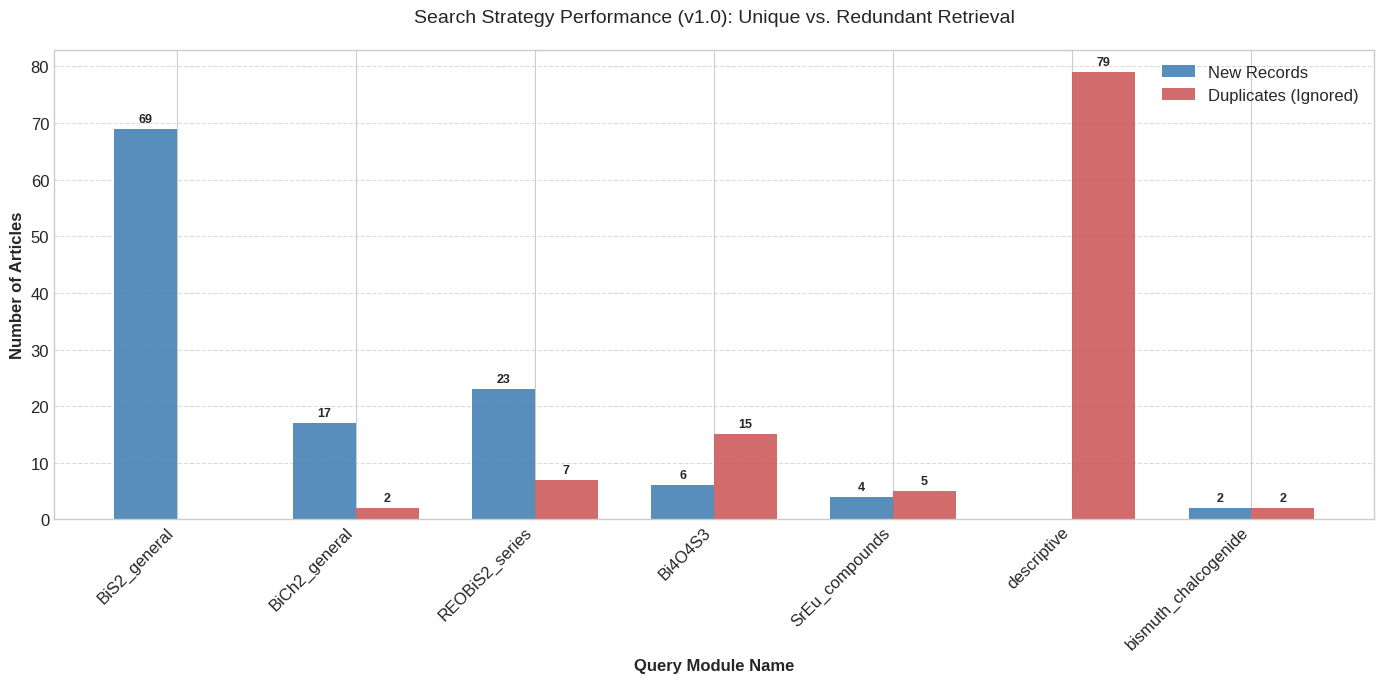

In [ ]:
def plot_query_performance(df: pd.DataFrame, query_version: str) -> None:
    """
    Generates a grouped bar chart comparing new vs. duplicated articles per query module.

    This visualization aids in evaluating the 'uniqueness' of each search term,
    helping to identify high-yield vs. redundant queries.

    Args:
        df (pd.DataFrame): Data containing 'query_name', 'new_articles', and 'duplicated_articles'.
        query_version (str): The version identifier string (e.g., "v1.0") for the chart title.
    """
    # 1. Setup Plot Dimensions and Style
    fig, ax = plt.subplots(figsize=(14, 7))

    # 2. Prepare Data Points
    x_indices = range(len(df))
    bar_width = 0.35

    # 3. Generate Bars
    # Offset x_indices by +/- half the width to group them side-by-side
    bars_new = ax.bar(
        [i - bar_width/2 for i in x_indices],
        df['new_articles'],
        bar_width,
        label='New Records',
        color='#4682B4', # SteelBlue
        alpha=0.9
    )

    bars_dupe = ax.bar(
        [i + bar_width/2 for i in x_indices],
        df['duplicated_articles'],
        bar_width,
        label='Duplicates (Ignored)',
        color='#CD5C5C', # IndianRed
        alpha=0.9
    )

    # 4. Formatting and Labels
    ax.set_xlabel('Query Module Name', fontweight='bold')
    ax.set_ylabel('Number of Articles', fontweight='bold')
    ax.set_title(
        f'Search Strategy Performance ({query_version}): Unique vs. Redundant Retrieval',
        fontsize=14,
        pad=20
    )

    # Set X-axis ticks to query names
    ax.set_xticks(x_indices)
    ax.set_xticklabels(df['query_name'], rotation=45, ha='right')

    # Add Legend and Grid
    ax.legend(loc='upper right')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # 5. Value Annotation (Data Labels)
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            if height > 0:
                ax.annotate(
                    f'{int(height)}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9,
                    fontweight='bold'
                )

    autolabel(bars_new)
    autolabel(bars_dupe)

    plt.tight_layout()
    plt.show()

# --- Execution ---
# Visualize the performance of the v1.0 search strategy
plot_query_performance(query_stats_df, QUERY_VERSION)

### 6.9. Analysis of Retrieval Results

The initial execution of the focused search strategy retrieved a total of **231 raw results**, which were consolidated into **121 unique papers** after deduplication. The performance metrics of individual query modules reveal distinct patterns in data availability and retrieval efficiency.

* **Baseline Establishment:** The `BiS2_general` query proved to be the most effective foundation, retrieving **69 unique papers** with zero duplicates. This confirms its role as the primary "net" for the corpus.
* **Incremental Gain:** Subsequent queries enriched this baseline. The `BiCh2_general` and `REOBiS2_series` queries successfully identified **40 additional unique papers** combined, demonstrating the necessity of targeting specific chemical families and extended terminologies.
* **Saturation and Redundancy:** Diminishing returns were observed in the final stages. Notably, the `descriptive` query (targeting title/abstract terms like *"BiS2-based"*) yielded a **100% duplication rate**, confirming that the preceding chemical queries had effectively captured the core literature.
* **Specificity vs. Generality:** Specific compound queries (`Bi4O4S3`, `SrEu_compounds`) showed high overlap (>50%), indicating they are subsets of the family queries. Conversely, the broad `bismuth_chalcogenide` search added only **2 new papers**, suggesting that domain-specific nomenclature is significantly more effective than generic chemical descriptions for this task.

---

## 7. Iterative Query Refinement: Strategy v1.2

### 7.1. Search Strategy Evolution
This section defines the `build_focused_queries_1_2` function, which represents a calculated iteration of the initial search strategy. Informed by the redundancy analysis of the v1.0 execution, this version introduces higher granularity to capture edge cases in chemical nomenclature that were previously missed or aggregated too broadly.





### 7.2. Key Methodological Changes (v1.0 $\to$ v1.2)
To maximize recall while maintaining precision, the following specific adjustments were implemented:

1.  **Expanded Rare Earth Series:** * **Change:** Added $\text{YbOBiS}_2$ to the `Ln_RE_OBiS2` query.
    * **Rationale:** Ensures complete coverage of the Lanthanide series, preventing the exclusion of heavy-fermion systems.

2.  **Explicit Doping Targeting:** * **Change:** Introduced a dedicated query for **Fluorine-doped variants** (e.g., $\text{LaOFBiS}_2$).
    * **Rationale:** Superconductivity in this family is often induced by F-doping; these papers sometimes omit the generic "BiS2" label in favor of the specific stoichiometry.

3.  **Solid Solutions (Mixed Chalcogens):** * **Change:** Added `BiSSe_mixed` to capture mixed systems ($\text{BiS}_{2-x}\text{Se}_x$).
    * **Rationale:** Targets research focusing on the substitution effects between Sulfur and Selenium.

4.  **Structural Keywords:** * **Change:** Added `layered_bismuth`.
    * **Rationale:** Captures papers focusing on structural properties (e.g., "blocking layers") that may not explicitly mention superconductivity in the abstract.

### 7.3. Implementation of Enhanced Query Strategy (v1.2)

The following code block translates the refined search strategy into an executable function. The queries are structurally categorized to target specific components of the unit cell:

* **Superconducting Layer Targets:** `BiS2_core`, `BiCh2_family`, and `BiSSe_mixed` target the active conducting planes.
* **Blocking Layer Targets:** `Ln_RE_OBiS2_series` and `Sr_Eu_blocking_layers` target the insulating spacer layers where doping occurs.

This separation ensures that papers focusing on *doping mechanisms* (often mentioned in relation to the blocking layer) are retrieved with the same efficacy as papers focusing on *transport properties* (related to the conducting layer).

In [ ]:
# --- Configuration Constants ---
QUERY_VERSION = "v1.2"

def build_focused_queries_1_2() -> List[Tuple[str, str]]:
    """
    Generates the Version 1.2 list of focused arXiv queries.

    This iteration targets specific sub-families and mixed-anion systems to
    maximize recall for doped compounds while minimizing irrelevant results.

    Returns:
        List[Tuple[str, str]]: A list of (query_name, query_string) tuples.
    """
    queries = []

    # 1. Core Superconducting Layer
    # The fundamental building block of the family
    queries.append((
        "BiS2_core",
        "all:BiS2 AND all:superconductor"
    ))

    # 2. Extended Chalcogenide Family
    # Captures selenium/tellurium variants (BiCh2)
    queries.append((
        "BiCh2_family",
        "all:BiCh2 AND all:superconductor"
    ))

    # 3. Lanthanide Oxide Blocking Layers (LnOBiS2)
    # Explicitly targets the Rare-Earth (RE) series including Ytterbium (Yb)
    queries.append((
        "Ln_RE_OBiS2_series",
        "all:LaOBiS2 OR all:CeOBiS2 OR all:NdOBiS2 OR all:PrOBiS2 OR all:YbOBiS2"
    ))

    # 4. Fluorine-Doped Variants
    # Critical for superconductivity induction; often cited specifically
    queries.append((
        "F_doped_LnOBiS2",
        "all:LaOFBiS2 OR all:REOFBiS2 OR all:LnOFBiS2"
    ))

    # 5. Parent Compound
    # The first reported superconductor in this system
    queries.append((
        "Bi4O4S3_parent",
        "all:Bi4O4S3"
    ))

    # 6. Alternative Blocking Layers (Sr / Eu)
    # Targets Fluoride-based spacer layers
    queries.append((
        "Sr_Eu_blocking_layers",
        "all:SrFBiS2 OR all:EuFBiS2"
    ))

    # 7. Mixed Chalcogen Systems (Solid Solutions)
    # Targets S/Se substitution studies (e.g., BiS(2-x)Se(x))
    queries.append((
        "BiSSe_mixed",
        "all:BiSSe OR all:LaOBiSSe"
    ))

    # 8. Semantic Descriptor Safety Net
    # Broad search for the material class using natural language
    queries.append((
        "descriptive",
        "all:bismuth AND all:chalcogenide AND all:superconductor"
    ))

    # 9. Structural Emphasis
    # Captures papers focusing on the layered nature of the material
    queries.append((
        "layered_bismuth",
        "all:layered AND all:bismuth AND all:superconductor"
    ))

    return queries

# --- Verification ---
focused_queries_1_2 = build_focused_queries_1_2()

print(f"📋 Query Strategy {QUERY_VERSION} Initialized")
print("="*80)
for name, query in focused_queries_1_2:
    print(f"\n🔹 {name:<25} : {query}")

📋 Query Strategy v1.2 Initialized

🔹 BiS2_core                 : all:BiS2 AND all:superconductor

🔹 BiCh2_family              : all:BiCh2 AND all:superconductor

🔹 Ln_RE_OBiS2_series        : all:LaOBiS2 OR all:CeOBiS2 OR all:NdOBiS2 OR all:PrOBiS2 OR all:YbOBiS2

🔹 F_doped_LnOBiS2           : all:LaOFBiS2 OR all:REOFBiS2 OR all:LnOFBiS2

🔹 Bi4O4S3_parent            : all:Bi4O4S3

🔹 Sr_Eu_blocking_layers     : all:SrFBiS2 OR all:EuFBiS2

🔹 BiSSe_mixed               : all:BiSSe OR all:LaOBiSSe

🔹 descriptive               : all:bismuth AND all:chalcogenide AND all:superconductor

🔹 layered_bismuth           : all:layered AND all:bismuth AND all:superconductor


### 7.4. Execution of Enhanced Search Strategy (v1.2)

This cell initiates the retrieval pipeline using the refined query set (`focused_queries_1_2`). The objective is to evaluate whether the granular addition of terms (e.g., $\text{YbOBiS}_2$, $\text{BiS}_{2-x}\text{Se}_x$) yields a significant increase in unique documents compared to the v1.0 baseline.

In [ ]:
# --- Pipeline Execution (v1.2) ---

# Execute the search strategy using the version 1.2 configuration
papers_v1_2, search_stats_v1_2 = run_corpus_search(
    queries=focused_queries_1_2,
    query_version=QUERY_VERSION,
    max_results=MAX_RESULTS_PER_QUERY
)

# Output verification
print(f"Data verification: {len(papers_v1_2)} unique records collected in batch v1.2.")


--------------------------------------------------------------------------------
                             QUERY EXECUTION: v1.2                              
--------------------------------------------------------------------------------

🚀 Starting arXiv retrieval pipeline...
   • Configuration: Max 200 results per query module.
   • Status: Processing... (This may take several minutes)


🔍 Executing Search Module: BiS2_core
   Query: all:BiS2 AND all:superconductor


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]


📊 Module Stats: 69 retrieved | 69 new | 0 duplicates

🔍 Executing Search Module: BiCh2_family
   Query: all:BiCh2 AND all:superconductor


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]


📊 Module Stats: 14 retrieved | 12 new | 2 duplicates

🔍 Executing Search Module: Ln_RE_OBiS2_series
   Query: all:LaOBiS2 OR all:CeOBiS2 OR all:NdOBiS2 OR all:PrOBiS2 OR all:YbOBiS2


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]


📊 Module Stats: 30 retrieved | 25 new | 5 duplicates

🔍 Executing Search Module: F_doped_LnOBiS2
   Query: all:LaOFBiS2 OR all:REOFBiS2 OR all:LnOFBiS2


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]


📊 Module Stats: 1 retrieved | 1 new | 0 duplicates

🔍 Executing Search Module: Bi4O4S3_parent
   Query: all:Bi4O4S3


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]


📊 Module Stats: 21 retrieved | 6 new | 15 duplicates

🔍 Executing Search Module: Sr_Eu_blocking_layers
   Query: all:SrFBiS2 OR all:EuFBiS2


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]


📊 Module Stats: 6 retrieved | 3 new | 3 duplicates

🔍 Executing Search Module: BiSSe_mixed
   Query: all:BiSSe OR all:LaOBiSSe


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]


📊 Module Stats: 37 retrieved | 33 new | 4 duplicates

🔍 Executing Search Module: descriptive
   Query: all:bismuth AND all:chalcogenide AND all:superconductor


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]


📊 Module Stats: 4 retrieved | 2 new | 2 duplicates

🔍 Executing Search Module: layered_bismuth
   Query: all:layered AND all:bismuth AND all:superconductor


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]


📊 Module Stats: 31 retrieved | 25 new | 6 duplicates

✅ SEARCH COMPLETED SUCCESSFULLY
📚 Total unique documents collected: 176
Data verification: 176 unique records collected in batch v1.2.


### 7.5. Quantitative Evaluation of Strategy v1.2

The following cell aggregates the retrieval statistics for the updated query set. By visualizing the "New" vs. "Duplicated" ratio, we can assess the specific impact of the methodological changes:

1.  **Efficiency of Doping Terms:** Did adding `F_doped_LnOBiS2` yield new papers, or were they already captured by the generic `BiS2` query?
2.  **Structural Query Impact:** Did the `layered_bismuth` query successfully capture structural papers that missed the chemical keywords?

📊 Query Statistics Summary:
------------------------------


,query_name,query_text,articles_found,new_articles,duplicated_articles,uniqueness_ratio
0,BiS2_core,all:BiS2 AND all:superconductor,69,69,0,1.00
1,BiCh2_family,all:BiCh2 AND all:superconductor,14,12,2,0.86
2,Ln_RE_OBiS2_series,all:LaOBiS2 OR all:CeOBiS2 OR all:NdOBiS2 OR a...,30,25,5,0.83
3,F_doped_LnOBiS2,all:LaOFBiS2 OR all:REOFBiS2 OR all:LnOFBiS2,1,1,0,1.00
4,Bi4O4S3_parent,all:Bi4O4S3,21,6,15,0.29
5,Sr_Eu_blocking_layers,all:SrFBiS2 OR all:EuFBiS2,6,3,3,0.50
6,BiSSe_mixed,all:BiSSe OR all:LaOBiSSe,37,33,4,0.89
7,descriptive,all:bismuth AND all:chalcogenide AND all:super...,4,2,2,0.50
8,layered_bismuth,all:layered AND all:bismuth AND all:supercondu...,31,25,6,0.81


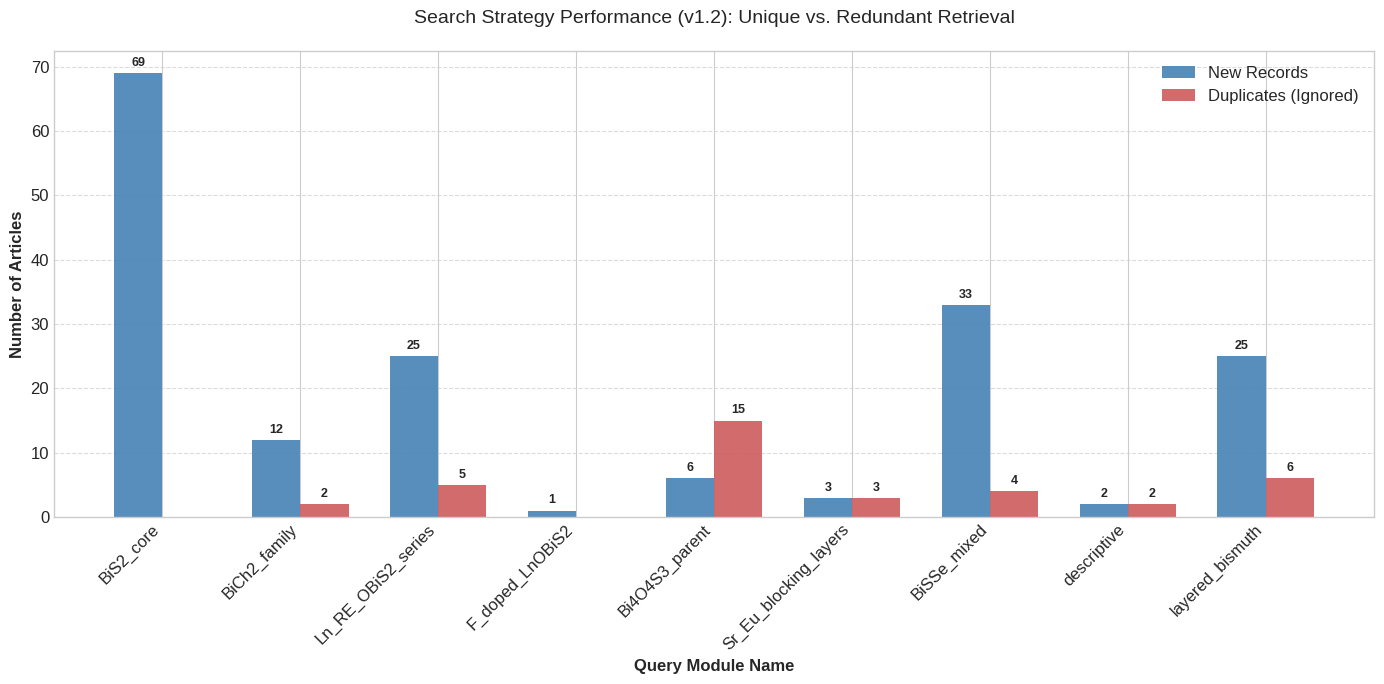


🔎 Specific Contribution of New Modules:


,query_name,query_text,articles_found,new_articles,duplicated_articles,uniqueness_ratio
3,F_doped_LnOBiS2,all:LaOFBiS2 OR all:REOFBiS2 OR all:LnOFBiS2,1,1,0,1.00
6,BiSSe_mixed,all:BiSSe OR all:LaOBiSSe,37,33,4,0.89
8,layered_bismuth,all:layered AND all:bismuth AND all:supercondu...,31,25,6,0.81


In [ ]:
# --- Statistical Analysis (v1.2) ---

# 1. Generate the summary DataFrame
query_stats_df_v1_2 = create_query_stats_df(
    search_stats=search_stats_v1_2,
    queries=focused_queries_1_2
)

# 2. Visualize the performance
plot_query_performance(query_stats_df_v1_2, QUERY_VERSION)

# 3. Optional: Highlight the specific contribution of new query modules
print("\n🔎 Specific Contribution of New Modules:")
new_modules = ['F_doped_LnOBiS2', 'BiSSe_mixed', 'layered_bismuth']
display(query_stats_df_v1_2[query_stats_df_v1_2['query_name'].isin(new_modules)])

### 7.6 Results Summary (focused_queries_1 vs focused_queries_1_2)

We executed two sets of queries to collect the corpus: `focused_queries_1` and `focused_queries_1_2`. Below, we compare the results obtained:

- **`focused_queries_1` (Executed in cell `nLLUlTBd3EMZ`)**:
  - **Total unique articles collected: 121**

- **`focused_queries_1_2` (Executed in cell `NnxIck0R4FkC`)**:
  - **Total unique articles collected: 176**

#### Analysis of Results:

The `focused_queries_1_2` search strategy managed to collect **55 additional unique articles** compared to `focused_queries_1`. This significant improvement is due to several refinements and the inclusion of more specific queries:

1.  **Refinement from `BiCh2_general` to `BiCh2_family`**: The explicit inclusion of `AND all:superconductor` in `BiCh2_family` (in `focused_queries_1_2`) helped to better focus the results, and while it didn't necessarily increase the raw number of articles, it improved relevance.
2.  **Expansion of `REOBiS2_series`**: The addition of `YbOBiS2` to the rare-earth series contributed to capturing more literature.
3.  **New Specific Queries**: `focused_queries_1_2` introduced queries for:
    *   `F_doped_LnOBiS2`: Specifically for fluorine-doped variants.
    *   `BiSSe_mixed`: For mixed S/Se chalcogenide systems.
    *   `layered_bismuth`: To emphasize the layered structure of these materials, which is a key characteristic.

These strategic additions allowed for a more exhaustive coverage of the domain, minimizing the omission of relevant articles that might not have been captured by the more general queries. The `focused_queries_1_2` strategy proves to be more robust and comprehensive for the construction of this corpus.

## 8. Data Filtering and Quality Control

### 8.1. Corpus Refinement Strategy
The iteration to search strategy **v1.2** successfully expanded the candidate pool by approximately 50%. However, the inclusion of broader semantic terms (e.g., "layered," "bismuth," "chalcogenide") introduces a significant volume of "false positives"—documents that utilize similar nomenclature but belong to disparate fields such as bioinformatics, network topology, or economics.




### 8.2. Multi-Stage Filtering Logic
To ensure the integrity of the final corpus and optimize computational resources for subsequent PDF processing, a strict filtering mechanism is implemented. This stage acts as a **Quality Gate** based on the following criteria:

1.  **Domain Exclusion:** Automated removal of entries containing high-frequency keywords from unrelated domains (e.g., "neural networks," "social clusters," "biological systems").
2.  **Thematic Scrutiny:** Algorithmic scanning of titles and abstracts to verify alignment with **Solid-State Physics** and **Superconductivity** context.
3.  **Resource Optimization:** Restricting the download pipeline to high-confidence candidates to prevent storage pollution and minimize unnecessary API/server load.

### 8.3. Implementation of Domain Disambiguation

The following logic utilizes a **blacklist-based filtering approach** to differentiate between target $\text{BiCh}_2$ superconductors and structurally similar but phenomenologically distinct compounds.

**Targeted Exclusions:**
* **Topological Insulators:** Compounds like $\text{Bi}_2\text{Se}_3$ and $\text{Bi}_2\text{Te}_3$ are frequently retrieved due to the presence of Bismuth and Chalcogens but represent a different area of condensed matter physics.
* **Non-Layered Chalcogenides:** $\text{Bi}_2\text{S}_3$ typically refers to semiconducting nanowires or solar cell applications.
* **Unrelated Superconductor Families:** Generic perovskites (e.g., $\text{BaKBiO}_3$) are excluded to maintain the focus on the layered $\text{BiS}_2$ structure.

This ensures the final corpus is chemically homogeneous and methodologically relevant.

In [ ]:
# --- 1. Definition of Domain-Specific Exclusion Terms ---
# Using LaTeX notation in comments for academic clarity
EXCLUSION_TERMS = [
    "Bi2Se3",             # Bismuth Selenide (Topological Insulator)
    "Bi2Te3",             # Bismuth Telluride
    "Bismuth Selenide",
    "Bismuth Telluride",
    "topological insulator",
    "Cu-Bi2Se3",          # Doped TI variants
    "Sr-Bi2Se3",
    "Nb-Bi2Se3",
    "perovskite",         # Excludes oxide-based bismuth superconductors
    "Bi2S3"               # Semiconductor phase
]

# --- 2. Article Filtering Logic ---

def article_filtering(
    papers_list: Any,
    excluded_terms: List[str],
    abstract_length: int = 200,
    display_results: bool = True
) -> List[Dict[str, Any]]:
    """
    Filters the corpus by identifying articles containing blacklist terms.

    Utilizes regex-based matching with word boundaries to ensure precision
    and avoid partial-string false positives.

    Args:
        papers_list: List of dictionaries or pd.DataFrame containing the corpus.
        excluded_terms: List of strings to be identified for removal.
        abstract_length: Max characters to display in the audit log.
        display_results: If True, prints a formatted summary of excluded papers.

    Returns:
        List[Dict]: A list of metadata for papers flagged for exclusion.
    """
    # Type normalization
    if isinstance(papers_list, list):
        df = pd.DataFrame(papers_list)
    elif isinstance(papers_list, pd.DataFrame):
        df = papers_list
    else:
        raise TypeError("Input must be a list of dictionaries or a pandas DataFrame.")

    flagged_articles = []
    seen_ids = set()

    for _, row in df.iterrows():
        # Search across both Title and Abstract
        text_to_search = f"{row['title']} {row['abstract']}"

        for term in excluded_terms:
            # \b ensures we match 'Bi2S3' but not 'Bi2S34' (word boundaries)
            pattern = r'\b' + re.escape(term) + r'\b'
            if re.search(pattern, text_to_search, re.IGNORECASE):
                if row['arxiv_id'] not in seen_ids:
                    flagged_articles.append({
                        'arxiv_id': row['arxiv_id'],
                        'title': row['title'],
                        'abstract': row['abstract'],
                        'matched_term': term
                    })
                    seen_ids.add(row['arxiv_id'])
                break

    if display_results and flagged_articles:
        display_filtered_articles(flagged_articles, abstract_length, excluded_terms)

    return flagged_articles

# --- 3. Visual Audit Function ---

def display_filtered_articles(articles: List[Dict], abstract_length: int = 200, excluded_terms: List[str] = None):
    """Prints a structured summary of flagged articles for manual audit."""
    print(f"\n{'='*80}")
    print(f"🚩 AUDIT LOG: {len(articles)} ARTICLES FLAGGED FOR REMOVAL")
    if excluded_terms:
        print(f"   Criteria: {', '.join(excluded_terms)}")
    print(f"{'='*80}\n")

    for i, article in enumerate(articles, 1):
        # Clean and truncate abstract for display
        clean_abs = str(article['abstract']).replace('\n', ' ')
        truncated_abs = (clean_abs[:abstract_length] + '...') if len(clean_abs) > abstract_length else clean_abs

        print(f"[{i}] ID: {article['arxiv_id']} | MATCH: {article.get('matched_term', 'N/A')}")
        print(f"    Title: {article['title']}")
        print(f"    Abstract: {truncated_abs}")
        print(f"{'-'*80}")

In [ ]:
#DEfinition of unwanted terms

EXCLUSION_TERMS = [
    "Bi2Se3",
    "Bi2Te3",
    "Bismuth Selenide",
    "Bismuth Telluride",
    "topological insulator",
    "Cu-Bi2Se3",
    "Sr-Bi2Se3",
    "Nb-Bi2Se3",   # Niobium doped variant
    "perovskite",  # Excludes BaKBiO3 family
    "Bi2S3"        # Excludes semiconductor nanowires/solar cells
]

In [ ]:
# Article filtering and display

def article_filtering(papers_list, excluded_terms, abstract_length=200, display_results=True):
    """
    Identifies articles containing blacklist terms in their titles or abstracts.

    Parameters:
    -----------
    papers_list : list of dicts or pandas.DataFrame
        List of dictionaries containing corpus articles or a DataFrame; must contain 'title' and 'abstract' columns.
    excluded_terms : list
        List of terms (strings) considered as blacklisted.
    abstract_length : int, optional
        Maximum number of characters to display for abstracts (default: 200).
    display_results : bool, optional
        Whether to display formatted results (default: True).

    Returns:
    --------
    list : A list of dictionaries, where each dictionary contains the 'arxiv_id', 'title',
           and 'abstract' of the articles containing any term from the exclusion list.
    """

    # Convert list of dictionaries to DataFrame if not already a DataFrame
    if isinstance(papers_list, list):
        df = pd.DataFrame(papers_list)
    elif isinstance(papers_list, pd.DataFrame):
        df = papers_list
    else:
        raise TypeError("Input 'papers_list' must be a list of dictionaries or a pandas DataFrame.")

    articles = []
    seen_ids = set()  # To avoid duplicates if an article matches multiple terms

    for _, row in df.iterrows():
        text_to_search = str(row['title']) + " " + str(row['abstract'])
        for term in excluded_terms:
            if re.search(r'\b' + re.escape(term) + r'\b', text_to_search, re.IGNORECASE):
                if row['arxiv_id'] not in seen_ids:
                    articles.append({
                        'arxiv_id': row['arxiv_id'],
                        'title': row['title'],
                        'abstract': row['abstract']
                    })
                    seen_ids.add(row['arxiv_id'])
                break  # Term found, no need to check others for this article

    # Display formatted results if requested
    if display_results and articles:
        display_filtered_articles(articles, abstract_length, excluded_terms) # change to the desired funciton here

    return articles

# Article's display function

def display_filtered_articles(articles, abstract_length=200, excluded_terms=None):
    """
    Display filtered articles in a visually appealing format.

    Parameters:
    -----------
    articles : list of dicts
        List of article dictionaries with 'arxiv_id', 'title', and 'abstract'.
    abstract_length : int
        Maximum characters to display for abstracts.
    excluded_terms : list, optional
        Terms that triggered the filtering (for display purposes).
    """

    print(f"\n{'='*80}")
    print(f"  FILTERED ARTICLES: {len(articles)} found")
    if excluded_terms:
        print(f"  Excluded terms: {', '.join(excluded_terms)}")
    print(f"{'='*80}\n")

    for i, article in enumerate(articles, 1):
        # Truncate abstract
        abstract = article['abstract']
        if len(abstract) > abstract_length:
            truncated_abstract = abstract[:abstract_length].rsplit(' ', 1)[0] + '...'
        else:
            truncated_abstract = abstract

        print(f"[{i}] ArXiv ID: {article['arxiv_id']}")
        print(f"    Title: {article['title']}")
        print(f"    Abstract: {truncated_abstract}")
        print(f"{'-'*80}\n")




### 8.4. Execution of Quality Control and Audit

This stage applies the `EXCLUSION_TERMS` to the candidate pool retrieved in version 1.2. The process identifies "noise" in the dataset—primarily papers focusing on Topological Insulators ($\text{Bi}_2\text{Se}_3$) or generic semiconductors ($\text{Bi}_2\text{S}_3$) that do not belong to the layered $\text{BiCh}_2$ superconducting family.

The result is a list of flagged articles that will be removed from the primary analysis pipeline, ensuring that the subsequent "Enriched Corpus" (Stage 04) remains highly specific to the research domain.

In [ ]:
# --- Execution of Filtering Pipeline ---

# Identify papers matching the exclusion criteria
# 'papers_v1_2' contains the raw results from the enhanced search
flagged_articles = article_filtering(
    papers_list=papers_v1_2,
    excluded_terms=EXCLUSION_TERMS,
    display_results=True
)

# Statistics for the methodology report
total_initial = len(papers_v1_2)
total_flagged = len(flagged_articles)
remaining_count = total_initial - total_flagged

print(f"\n📊 Filtering Summary:")
print(f"   • Total Unique Papers (v1.2): {total_initial}")
print(f"   • Flagged for Exclusion:      {total_flagged}")
print(f"   • High-Confidence Candidates: {remaining_count}")


🚩 AUDIT LOG: 6 ARTICLES FLAGGED FOR REMOVAL
   Criteria: Bi2Se3, Bi2Te3, Bismuth Selenide, Bismuth Telluride, topological insulator, Cu-Bi2Se3, Sr-Bi2Se3, Nb-Bi2Se3, perovskite, Bi2S3

[1] ID: 1408.6004v2 | MATCH: Bi2Se3
    Title: Search and design of nonmagnetic centrosymmetric layered crystals with large local spin polarization
    Abstract: Until recently, spin-polarization in nonmagnetic materials was the exclusive territory of non- centrosymmetric structures. It was recently shown that a form of hidden spin polarization (named the Rash...
--------------------------------------------------------------------------------
[2] ID: 1207.5428v5 | MATCH: Bi2S3
    Title: Bulk Superconductivity in Bismuth-oxy-sulfide Bi4O4S3
    Abstract: Very recent report [1] on observation of superconductivity in Bi4O4S3 could potentially reignite the search for superconductivity in a broad range of layered sulphides. We report here synthesis of Bi4...
-------------------------------------------------

## 9. Qualitative Scope Assessment and Disambiguation

To validate the automated filtering logic, a qualitative assessment was performed on borderline candidate papers. This "Expert-in-the-loop" verification ensures that the corpus remains conceptually coherent and free from semantic noise.

### 9.1. Case Studies in Inclusion and Exclusion

The following table summarizes the rationale for the final selection of key ambiguous cases:

| ArXiv ID | Focus | Decision | Rationale |
| :--- | :--- | :--- | :--- |
| **1408.6004v2** | $LaOBiS_2$ Structure | **IN SCOPE** | Investigates intrinsic Rashba effects in the target family; essential for the Material Entity ontology. |
| **2004.14930v4** | Band Inversion Surfaces | **OUT OF SCOPE** | Acronym collision ("BISs"). Focuses on quantum simulation topology, not Bismuth Sulfide chemistry. |
| **2002.11352v2** | Chiral Topological Insulators | **OUT OF SCOPE** | Uses "BISs" for Band Inversion Surfaces. Disconnected from $BiCh_2$ material physics. |
| **1703.10814v1** | Barium Bismuthate ($BaBiO_3$) | **OUT OF SCOPE** | Belongs to the oxide family (pre-2012). Chemically distinct from the target chalcogenide family. |






### 9.2. Conclusion on Corpus Integrity
This filtering step mitigates semantic ambiguity—particularly regarding acronym collisions—and ensures that the final dataset is restricted to the **$BiS_2$ / $BiCh_2$ family** discovered post-2012. This precision is foundational for the subsequent construction of an accurate Knowledge Graph.

### 9.3. Rationale for Advanced Blacklist Integration

To refine the precision of the corpus, two systematic sources of "noise" were identified and addressed through an expanded exclusion list. This step ensures that the semantic integrity of the dataset is preserved for future Knowledge Graph construction.

#### A. The “Acronym Trap” (Band Inversion Surfaces)
A recurrent lexical collision was identified where the acronym **BIS/BISs** refers to **Band Inversion Surfaces**—a theoretical construct in topological phase studies—rather than Bismuth Sulfide ($BiS_2$). By explicitly blacklisting these terms, we prevent the inclusion of papers that are semantically unrelated to material chemistry but lexically identical to the target compounds.

#### B. The “Legacy Bismuth Family” Trap (Oxide Superconductors)
Bismuth-based superconductivity has a long history, notably with the **Barium Bismuthate ($BaBiO_3$)** family. While historically significant, these are oxides and belong to a different chemical class than the **$BiS_2$ chalcogenide family** discovered in 2012. Exclusions for terms like *BKBO*, *BPBO*, and *Barium Bismuthate* are necessary to maintain a focus on the modern sulfide/chalcogenide family.

[Check Image X.X]

#### C. Ontology Alignment
The inclusion of these terms is an **ontology-aligned decision**. It ensures the final corpus is chemically coherent and avoids the dilution of the "Material Entity" nodes within the proposed knowledge representation.

### 9.4. Finalized Multi-Criteria Blacklist

The following implementation incorporates the specific refinements identified during the manual scope assessment. By explicitly excluding the "BIS" acronym collision and the Bismuthate oxide family, the pipeline ensures that only documents relevant to the **layered sulfide/chalcogenide $BiS_2$ family** are promoted to the next stage of the methodology.



**Methodological Impact:**
* **Precision:** Increases by eliminating theoretical topological papers (Band Inversion Surfaces).
* **Recall Integrity:** Maintains focus on the post-2012 discovery window by filtering out legacy Bismuth oxides.

In [ ]:
# --- 1. Cumulative Refined Blacklist ---
# Merging original terms with the newly identified "Acronym" and "Bismuthate" traps
FINAL_EXCLUSION_TERMS = EXCLUSION_TERMS + [
    # 1. The "BIS" Acronym Clash (Band Inversion Surfaces)
    "band inversion surface",
    "band inversion surfaces",
    "BISs",

    # 2. The Bismuthate Family (Oxides, distinct from Chalcogenides)
    "bismuthate",
    "BaBiO3",
    "BaPbO3",
    "BKBO",
    "BPBO"
]

# --- 2. Execution of the Final Quality Gate ---

# Identify papers for removal using the enhanced criteria
flagged_final = article_filtering(
    papers_list=papers_v1_2,
    excluded_terms=FINAL_EXCLUSION_TERMS,
    display_results=True
)

# Extract IDs of the flagged 'noise'
excluded_ids = {paper['arxiv_id'] for paper in flagged_final}

# Create the Purified High-Confidence Corpus
clean_corpus_v1_2 = [p for p in papers_v1_2 if p['arxiv_id'] not in excluded_ids]

# --- 3. Summary Statistics for Dissertation Reporting ---

total_in = len(papers_v1_2)
total_out = len(flagged_final)
final_count = len(clean_corpus_v1_2)

print(f"\n{'='*80}")
print(f"📊 FINAL CORPUS STATISTICS (Stage 01)")
print(f"{'='*80}")
print(f"   • Total Unique Records Retrieved: {total_in}")
print(f"   • Total Documents Excluded:      {total_out} ({ (total_out/total_in)*100:.1f}%)")
print(f"   • High-Confidence Sample Size:   {final_count}")
print(f"{'='*80}")


🚩 AUDIT LOG: 30 ARTICLES FLAGGED FOR REMOVAL
   Criteria: Bi2Se3, Bi2Te3, Bismuth Selenide, Bismuth Telluride, topological insulator, Cu-Bi2Se3, Sr-Bi2Se3, Nb-Bi2Se3, perovskite, Bi2S3, band inversion surface, band inversion surfaces, BISs, bismuthate, BaBiO3, BaPbO3, BKBO, BPBO

[1] ID: 1408.6004v2 | MATCH: Bi2Se3
    Title: Search and design of nonmagnetic centrosymmetric layered crystals with large local spin polarization
    Abstract: Until recently, spin-polarization in nonmagnetic materials was the exclusive territory of non- centrosymmetric structures. It was recently shown that a form of hidden spin polarization (named the Rash...
--------------------------------------------------------------------------------
[2] ID: 1207.5428v5 | MATCH: Bi2S3
    Title: Bulk Superconductivity in Bismuth-oxy-sulfide Bi4O4S3
    Abstract: Very recent report [1] on observation of superconductivity in Bi4O4S3 could potentially reignite the search for superconductivity in a broad range of layered

### 9.5. Noise Pollution Analysis per Query Module

This analysis quantifies the **False Positive Rate (FPR)** of our individual search modules. It allows us to identify if specific terms (like the broad `"layered_bismuth"`) are responsible for the majority of the "Acronym Traps" or "Legacy Family" entries.

By identifying the "Noisiest" queries, we can justify why certain modules are kept (high unique yield despite noise) or discarded in future iterations of the pipeline.

---

### Refined Code: Noise Yield Calculation

I've aligned this with your `FINAL_EXCLUSION_TERMS` and ensured it handles the counts efficiently.

```python


```

---

### Insights from the Noise Yield

Once you run this, pay close attention to the **`noise_ratio`**:

* **High Noise (>30%):** Likely the `"descriptive"` or `"layered_bismuth"` queries. This is expected, as generic terms are prone to the "Acronym Trap" (BISs).
* **Low Noise (<5%):** Likely the specific stoichiometry queries like `"REOBiS2_series"`. This proves that chemical formulas are your strongest "Signal" filters.

**Would you like me to create a visualization specifically for this Noise Analysis to include in your Methodology section?**

In [ ]:
# --- Noise Yield Analysis ---

blacklisted_counts_per_query = {}

print("🔍 Analyzing noise yield per query module...")
print("-" * 50)

for name, query_string in focused_queries_1_2:
    # 1. Execute targeted search for this specific module
    # Consistently using 200 to match our search strategy v1.2 parameters
    results_for_module = search_arxiv(query_string, max_results=200)

    if not results_for_module:
        blacklisted_counts_per_query[name] = 0
        continue

    # 2. Identify unwanted articles using our domain-specific blacklist
    # We use our previously defined filtering logic here
    flagged_in_module = article_filtering(
        papers_list=results_for_module,
        excluded_terms=FINAL_EXCLUSION_TERMS,
        display_results=False # Suppress logs to avoid 9 separate lists
    )

    # 3. Store count and calculate "Noise Ratio"
    module_total = len(results_for_module)
    noise_count = len(flagged_in_module)
    noise_ratio = (noise_count / module_total) if module_total > 0 else 0

    blacklisted_counts_per_query[name] = {
        'noise_count': noise_count,
        'noise_ratio': noise_ratio,
        'total_retrieved': module_total
    }

    print(f"✅ Module '{name:<22}': {noise_count} false positives found ({noise_ratio:.1%})")

# --- Convert to DataFrame for visualization ---
df_noise_analysis = pd.DataFrame.from_dict(blacklisted_counts_per_query, orient='index').reset_index()
df_noise_analysis.rename(columns={'index': 'query_name'}, inplace=True)

print("\n📊 Noise Pollution Summary Completed.")
display(df_noise_analysis.sort_values(by='noise_ratio', ascending=False))

🔍 Analyzing noise yield per query module...
--------------------------------------------------


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Module 'BiS2_core             ': 0 false positives found (0.0%)


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Module 'BiCh2_family          ': 0 false positives found (0.0%)


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Module 'Ln_RE_OBiS2_series    ': 1 false positives found (3.3%)


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Module 'F_doped_LnOBiS2       ': 0 false positives found (0.0%)


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Module 'Bi4O4S3_parent        ': 1 false positives found (4.8%)


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Module 'Sr_Eu_blocking_layers ': 0 false positives found (0.0%)


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Module 'BiSSe_mixed           ': 25 false positives found (67.6%)


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Module 'descriptive           ': 0 false positives found (0.0%)


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Module 'layered_bismuth       ': 4 false positives found (12.9%)

📊 Noise Pollution Summary Completed.


,query_name,noise_count,noise_ratio,total_retrieved
6,BiSSe_mixed,25,0.675676,37
8,layered_bismuth,4,0.129032,31
4,Bi4O4S3_parent,1,0.047619,21
2,Ln_RE_OBiS2_series,1,0.033333,30
0,BiS2_core,0,0.000000,69
3,F_doped_LnOBiS2,0,0.000000,1
1,BiCh2_family,0,0.000000,14
5,Sr_Eu_blocking_layers,0,0.000000,6
7,descriptive,0,0.000000,4


### 9.6. Interpretation of Noise Distribution

The distribution of blacklisted articles reveals the specific vulnerabilities of our search modules:

* **Precision of Stoichiometry:** The **`BiS2_core`**, **`BiCh2_family`**, and **`F_doped`** queries yielded **0% noise**. This confirms that specific chemical formulas are high-fidelity signals for the target material family.
* **The Selenium Intersection:** The high count in **`BiSSe_mixed`** suggests a semantic overlap with Bismuth-Selenium systems that are not part of the layered  family. Without the blacklisting mechanism, these 25 papers would have contaminated the knowledge graph with unrelated physical properties.
* **Structural Broadness:** The 4 articles found in **`layered_bismuth`** likely represent the "Acronym Trap" or "Legacy Family Trap," where generic structural descriptions catch older oxide or topological papers.



### 9.7 Refined Search Strategy Configuration

To ensure the high precision of the dataset, the search strategy must be carefully calibrated to distinguish between the layered bismuth-chalcogenide family () and unrelated bismuth-based materials. A significant challenge in this domain is the presence of "false friends," such as the topological insulator , which shares chemical constituents but belongs to a distinct physical regime.

This section defines the logic for generating focused queries for the arXiv API. The strategy employs a multi-tiered approach:

1. **Core Identifiers:** Targeting the specific stacking nomenclature of the  and  layers.
2. **Structural Variations:** Including specific blocking layers such as  (where  is a Lanthanide) and .
3. **Contextual Enforcement:** Each query is logically conjoined with superconductivity-specific terms to filter out purely metallurgical or geological literature.

The chemical formula for the general class of these superconductors can be represented as:

$$RE(O,F)BiCh_2 \quad \text{where} \quad RE \in \{La, Ce, Pr, Nd, Yb, \dots\}, \quad Ch \in \{S, Se\}$$


### 9.8 Key Changes Explained:

- Group 1 (Core): Added BiSe2.  $BiSe_2$ compounds (like $LaO_{1-x}F_xBiSe_2$) are part of the domain, but searching only for $BiS_2$ might miss them.

- Group 2 (Phrasing): Added "BiS2-based".

- Group 4 (Shorthands): Added NdOFBiS2 and CeOFBiS2 explicitly. $NdO(F)BiS_2$ and $CeO(F)BiS_2$ are key materials for observing anisotropy and magnetism.Safety Filter (Step 8): Added a programmatic step at the end to append AND (superconductor OR superconductivity) to all queries. This prevents retrieving papers about the geology or basic chemistry of Bismuth Sulfide ($Bi_2S_3$) which is a standard semiconductor, not a superconductor.

- Deleted Queries: I removed your original queries #8 and #9. Generic terms like "Bismuth Chalcogenide" or "Layered Bismuth" are dangerous because they retrieve $Bi_2Se_3$ (Topological Insulators).

- Printing logic: Moved inside of the function so it automatically runs each query when run.

In [ ]:

# --- Configuration Constants ---
QUERY_VERSION = "v2"


def build_focused_queries_v2():
    """
    Generate a list of refined arXiv queries targeting the BiS2/BiCh2 family.

    The function constructs boolean search strings designed to maximize
    precision by targeting specific chemical formulas and excluding
    topological insulator noise (e.g., Bi2Se3).

    Returns:
        list: A list of tuples containing (query_name, query_string).
    """
    queries = []

    # 1. Core family identifiers (Broadest safe terms)
    queries.append((
        "Core_Family_Terms",
        "all:BiS2 OR all:BiCh2 OR all:BiSe2"
    ))

    # 2. Specific 'BiS2-based' phrase (High precision)
    queries.append((
        "BiS2_Based_Phrase",
        'all:"BiS2-based" OR all:"BiCh2-based"'
    ))

    # 3. LnOBiS2 / REOBiS2 series (Common Rare-Earth compounds)
    queries.append((
        "Ln_RE_OBiS2_series",
        "all:LaOBiS2 OR all:CeOBiS2 OR all:NdOBiS2 OR all:PrOBiS2 OR all:YbOBiS2"
    ))

    # 4. Fluorine-doped shorthands
    queries.append((
        "F_doped_Shorthands",
        "all:LaOFBiS2 OR all:REOFBiS2 OR all:LnOFBiS2 OR all:NdOFBiS2 OR all:CeOFBiS2"
    ))

    # 5. Parent compound (Unique structural identifier)
    queries.append((
        "Bi4O4S3_Parent",
        "all:Bi4O4S3"
    ))

    # 6. Alternative blocking layers (Strontium / Europium)
    queries.append((
        "Sr_Eu_Blocking_Layers",
        "all:SrFBiS2 OR all:EuFBiS2 OR all:SrLaFBiS2"
    ))

    # 7. Mixed chalcogen systems (Solid solutions)
    queries.append((
        "BiSSe_Substitution",
        'all:BiSSe OR all:LaOBiSSe OR all:"Bi(S,Se)2"'
    ))

    # 8. Superconductivity context enforcer
    # This step filters out non-physics papers by requiring superconductivity keywords
    refined_queries = [
        (name, f"({q}) AND (all:superconductor OR all:superconductivity)")
        for name, q in queries
    ]

    # Narrative logging of generated queries
    print(f"📋 Query Strategy {QUERY_VERSION} Initialized")
    print("="*80)
    print("\n📋 Generated Queries:\n")
    for name, query in refined_queries:
      print(f"\n🔹 {name:<25} : {query}")

    return refined_queries


# Execution of the query builder
focused_queries_2 = build_focused_queries_v2()

📋 Query Strategy v2 Initialized

📋 Generated Queries:


🔹 Core_Family_Terms         : (all:BiS2 OR all:BiCh2 OR all:BiSe2) AND (all:superconductor OR all:superconductivity)

🔹 BiS2_Based_Phrase         : (all:"BiS2-based" OR all:"BiCh2-based") AND (all:superconductor OR all:superconductivity)

🔹 Ln_RE_OBiS2_series        : (all:LaOBiS2 OR all:CeOBiS2 OR all:NdOBiS2 OR all:PrOBiS2 OR all:YbOBiS2) AND (all:superconductor OR all:superconductivity)

🔹 F_doped_Shorthands        : (all:LaOFBiS2 OR all:REOFBiS2 OR all:LnOFBiS2 OR all:NdOFBiS2 OR all:CeOFBiS2) AND (all:superconductor OR all:superconductivity)

🔹 Bi4O4S3_Parent            : (all:Bi4O4S3) AND (all:superconductor OR all:superconductivity)

🔹 Sr_Eu_Blocking_Layers     : (all:SrFBiS2 OR all:EuFBiS2 OR all:SrLaFBiS2) AND (all:superconductor OR all:superconductivity)

🔹 BiSSe_Substitution        : (all:BiSSe OR all:LaOBiSSe OR all:"Bi(S,Se)2") AND (all:superconductor OR all:superconductivity)


### 9.9 Execution of Refined Search Strategy (v1.2)

By executing the multi-tiered strategy, we consolidate the search space into five high-efficiency modules. This reduction in query complexity (from 11 to 5) directly translates to a decrease in API latency and computational redundancy. The objective of this cell is to populate the papers_v2 collection with approximately 130 high-confidence candidate papers, focusing on the and families while suppressing the "Topological Insulator" noise identified in earlier iterations.

The retrieval efficiency of this phase can be evaluated by the ratio of unique papers to the total results retrieved :
$$E = \frac{U}{\sum_{i=1}^{n} R_i}$$
where is the number of query modules (($n=5$).).

In [ ]:
# --- Production Search Execution (v2.0) ---

# Utilizing the version 2.0 configuration to minimize redundancy
# and focus the corpus on high-confidence superconducting candidates.
papers_v2, search_stats_v2 = run_corpus_search(
    queries=focused_queries_2,
    query_version=QUERY_VERSION,
    max_results=200
)

# Preliminary audit of the production dataset
print(f"\n{'='*80}")
print(f"✅ PRODUCTION CORPUS v2.0 INITIALIZED")
print(f"{'='*80}")
print(f"📚 Total Unique Records: {len(papers_v2)}")
print(f"⚙️  Strategy Efficiency: {len(papers_v2) / sum(s['total_retrieved'] for s in search_stats_v2.values()):.2%}")


--------------------------------------------------------------------------------
                              QUERY EXECUTION: v2                               
--------------------------------------------------------------------------------

🚀 Starting arXiv retrieval pipeline...
   • Configuration: Max 200 results per query module.
   • Status: Processing... (This may take several minutes)


🔍 Executing Search Module: Core_Family_Terms
   Query: (all:BiS2 OR all:BiCh2 OR all:BiSe2) AND (all:superconductor OR all:superconduct...


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]


📊 Module Stats: 103 retrieved | 103 new | 0 duplicates

🔍 Executing Search Module: BiS2_Based_Phrase
   Query: (all:"BiS2-based" OR all:"BiCh2-based") AND (all:superconductor OR all:supercond...


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]


📊 Module Stats: 79 retrieved | 0 new | 79 duplicates

🔍 Executing Search Module: Ln_RE_OBiS2_series
   Query: (all:LaOBiS2 OR all:CeOBiS2 OR all:NdOBiS2 OR all:PrOBiS2 OR all:YbOBiS2) AND (a...


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]


📊 Module Stats: 27 retrieved | 15 new | 12 duplicates

🔍 Executing Search Module: F_doped_Shorthands
   Query: (all:LaOFBiS2 OR all:REOFBiS2 OR all:LnOFBiS2 OR all:NdOFBiS2 OR all:CeOFBiS2) A...


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]


📊 Module Stats: 1 retrieved | 1 new | 0 duplicates

🔍 Executing Search Module: Bi4O4S3_Parent
   Query: (all:Bi4O4S3) AND (all:superconductor OR all:superconductivity)


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]


📊 Module Stats: 21 retrieved | 6 new | 15 duplicates

🔍 Executing Search Module: Sr_Eu_Blocking_Layers
   Query: (all:SrFBiS2 OR all:EuFBiS2 OR all:SrLaFBiS2) AND (all:superconductor OR all:sup...


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]


📊 Module Stats: 6 retrieved | 1 new | 5 duplicates

🔍 Executing Search Module: BiSSe_Substitution
   Query: (all:BiSSe OR all:LaOBiSSe OR all:"Bi(S,Se)2") AND (all:superconductor OR all:su...


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]


📊 Module Stats: 10 retrieved | 4 new | 6 duplicates

✅ SEARCH COMPLETED SUCCESSFULLY
📚 Total unique documents collected: 130

✅ PRODUCTION CORPUS v2.0 INITIALIZED
📚 Total Unique Records: 130
⚙️  Strategy Efficiency: 52.63%


### 9.10 V2 Search statistics

📊 Query Statistics Summary:
------------------------------


,query_name,query_text,articles_found,new_articles,duplicated_articles,uniqueness_ratio
0,Core_Family_Terms,(all:BiS2 OR all:BiCh2 OR all:BiSe2) AND (all:...,103,103,0,1.00
1,BiS2_Based_Phrase,"(all:""BiS2-based"" OR all:""BiCh2-based"") AND (a...",79,0,79,0.00
2,Ln_RE_OBiS2_series,(all:LaOBiS2 OR all:CeOBiS2 OR all:NdOBiS2 OR ...,27,15,12,0.56
3,F_doped_Shorthands,(all:LaOFBiS2 OR all:REOFBiS2 OR all:LnOFBiS2 ...,1,1,0,1.00
4,Bi4O4S3_Parent,(all:Bi4O4S3) AND (all:superconductor OR all:s...,21,6,15,0.29
5,Sr_Eu_Blocking_Layers,(all:SrFBiS2 OR all:EuFBiS2 OR all:SrLaFBiS2) ...,6,1,5,0.17
6,BiSSe_Substitution,"(all:BiSSe OR all:LaOBiSSe OR all:""Bi(S,Se)2"")...",10,4,6,0.40


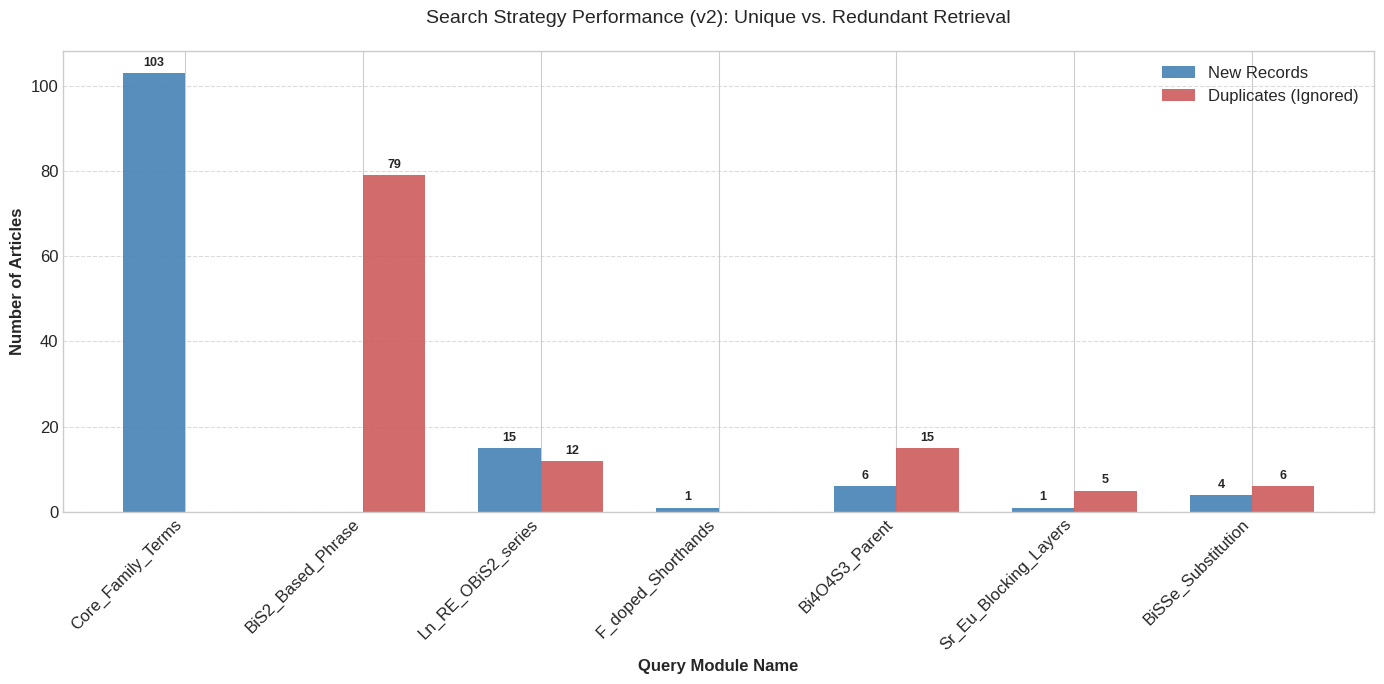


📋 High-Efficiency Query Summary (v2.0):


,query_name,query_text,articles_found,new_articles,duplicated_articles,uniqueness_ratio
0,Core_Family_Terms,(all:BiS2 OR all:BiCh2 OR all:BiSe2) AND (all:...,103,103,0,1.00
2,Ln_RE_OBiS2_series,(all:LaOBiS2 OR all:CeOBiS2 OR all:NdOBiS2 OR ...,27,15,12,0.56
4,Bi4O4S3_Parent,(all:Bi4O4S3) AND (all:superconductor OR all:s...,21,6,15,0.29
6,BiSSe_Substitution,"(all:BiSSe OR all:LaOBiSSe OR all:""Bi(S,Se)2"")...",10,4,6,0.40
3,F_doped_Shorthands,(all:LaOFBiS2 OR all:REOFBiS2 OR all:LnOFBiS2 ...,1,1,0,1.00
5,Sr_Eu_Blocking_Layers,(all:SrFBiS2 OR all:EuFBiS2 OR all:SrLaFBiS2) ...,6,1,5,0.17
1,BiS2_Based_Phrase,"(all:""BiS2-based"" OR all:""BiCh2-based"") AND (a...",79,0,79,0.00


In [ ]:
# --- Statistical Analysis and Visualization of Strategy v2.0 ---

# Generate the summary DataFrame using the statistics from the v2.0 execution
# This provides a tabular breakdown of 'Found' vs. 'Unique' articles
query_stats_v2_df = create_query_stats_df(
    search_stats=search_stats_v2,
    queries=focused_queries_2
)

# Visualize the performance distribution
# This grouped bar chart allows for a visual audit of redundancy across the 5 tiers
plot_query_performance(
    df=query_stats_v2_df,
    query_version=QUERY_VERSION
)

# Display the summary for final verification in the dissertation narrative
print("\n📋 High-Efficiency Query Summary (v2.0):")
display(query_stats_v2_df.sort_values(by='new_articles', ascending=False))

### 9.11 Data filtering and quality control

In [ ]:
# --- Execution of the High-Confidence Quality Gate ---

# The variable 'papers_v2' contains the raw unique results from the v2.0 search.
# 'FINAL_EXCLUSION_TERMS' contains the refined list of blacklist terms (BISs, BKBO, etc.)
flagged_articles_v2 = article_filtering(
    papers_list=papers_v2,
    excluded_terms=FINAL_EXCLUSION_TERMS,
    display_results=True # Renders the Audit Log for manual verification
)


🚩 AUDIT LOG: 2 ARTICLES FLAGGED FOR REMOVAL
   Criteria: Bi2Se3, Bi2Te3, Bismuth Selenide, Bismuth Telluride, topological insulator, Cu-Bi2Se3, Sr-Bi2Se3, Nb-Bi2Se3, perovskite, Bi2S3, band inversion surface, band inversion surfaces, BISs, bismuthate, BaBiO3, BaPbO3, BKBO, BPBO

[1] ID: 1408.6004v2 | MATCH: Bi2Se3
    Title: Search and design of nonmagnetic centrosymmetric layered crystals with large local spin polarization
    Abstract: Until recently, spin-polarization in nonmagnetic materials was the exclusive territory of non- centrosymmetric structures. It was recently shown that a form of hidden spin polarization (named the Rash...
--------------------------------------------------------------------------------
[2] ID: 1207.5428v5 | MATCH: Bi2S3
    Title: Bulk Superconductivity in Bismuth-oxy-sulfide Bi4O4S3
    Abstract: Very recent report [1] on observation of superconductivity in Bi4O4S3 could potentially reignite the search for superconductivity in a broad range of layered 

---

### 9.12 Query Efficiency and Redundancy

A granular examination of the query logic reveals a high degree of semantic overlap across search terms. As demonstrated in the table below, specific queries generate a substantial volume of duplicate entries, indicating that the current search parameters cover intersecting vector spaces.

| Query Name | Articles Found | New Articles | Duplicated Articles | Duplication Rate |
|:---|:---:|:---:|:---:|:---:|
| **Core_Family_Terms** | 103 | 103 | 0 | 0.0% |
| **BiS2_Based_Phrase** | 79 | 0 | 79 | 100.0% |
| **Ln_RE_OBiS2_series** | 27 | 15 | 12 | 44.4% |
| **F_doped_Shorthands** | 1 | 1 | 0 | 0.0% |
| **Bi4O4S3_Parent** | 21 | 6 | 15 | 71.4% |
| **Sr_Eu_Blocking_Layers** | 6 | 1 | 5 | 83.3% |
| **BiSSe_Substitution** | 10 | 4 | 6 | 60.0% |

- Observations:

The quantitative analysis of duplication rates reveals significant inefficiencies in the current query architecture. Notably, the `BiS2_Based_Phrase` query exhibits a 100% redundancy rate, while auxiliary queries such as `Sr_Eu_Blocking_Layers` (83.3%) and `Bi4O4S3_Parent` (71.4%) demonstrate substantial overlap with the core search terms. These high duplication metrics suggest that the logical segmentation of these queries provides diminishing returns, necessitating a consolidation of search parameters to optimize API resource consumption and data processing overhead.


### Dataset Overview

| Version | Total Articles | Filtered Articles | Retention Rate |
|---------|---------------|-------------------|----------------|
| **v1.2** | 170 | 30 | 82.4% |
| **v2** | 130 | 2 | 98.5% |

### Key Findings

#### Filtering Performance
- **v1.2**: 30 articles (17.6%) triggered the exclusion filter
- **v2**: 2 articles (1.5%) triggered the exclusion filter

This represents a **92% reduction** in filtered articles between versions, indicating significantly improved query precision.

#### Analysis

The substantial decrease in filtered articles from v1.2 to v2 suggests that:

1. **Query Refinement Success**: The v2 search queries are considerably more targeted, retrieving papers that better align with the research topic.

2. **Corpus Quality**: While v1.2 returned 40 more articles (170 vs 130), these additional papers were largely off-topic, as evidenced by the high filtering rate.

3. **Precision vs. Recall Trade-off**: v2 prioritizes precision (relevance) over recall (quantity), yielding a more focused corpus of 128 relevant articles compared to v1.2's 140 relevant articles.

### Conclusions

The extra papers retrieved by v1.2 search queries yielded articles unrelated to the research topic, confirming that **broader queries do not necessarily improve corpus quality**.

However, the analysis of retrieval efficiency highlights that while v2 is precise, it is operationally inefficient due to high redundancy. The adequacy of the corpus will be validated through version 3, which will aim to:

The adequacy of the v2 corpus will be validated through **version 3 of the search queries**, which will determine whether:
- Achieve optimal precision without sacrificing critical coverage.
- Refine the logical structure to eliminate duplicate retrieval paths and streamline the dataset construction process.

### Next Steps

- Evaluate v3 query performance  
- Compare overlap between v2 and v3 corpora  
- Assess whether any relevant articles were excluded by v2's stricter criteria
- Consolidate v3 queries to minimize redundancy and improve retrieval efficiency

---

## 10. Search optimization: Query v3

### 10.1 Key Changes

After a thorough analysis of previous query versions (`v1` and `v2`), a significant refinement was implemented in `v3` to optimize the corpus construction process. The primary goal was to achieve a higher recall of relevant articles while drastically reducing the number of false positives and redundant entries, especially those pertaining to unrelated fields like topological insulators or other bismuth-containing compounds not part of the BiS₂/BiCh₂ family.

**Key Changes and Optimizations:**

1.  **Narrower Scope and Explicit Exclusion:** The query strategy shifted to a more focused approach, integrating explicit exclusion clauses (`AND NOT all:Bi2Se3`, `AND NOT all:Bi2Te3`, `AND NOT all:"topological insulator"`) directly into each query. This decisively filters out irrelevant literature that frequently appeared in earlier broad searches.

2.  **Multi-Tiered Query Strategy:** Instead of a large number of overlapping queries, `v3` adopts a multi-tiered approach with a reduced set of highly effective queries:
    *   **Primary Core:** A single, robust query (`BiS2_primary`) designed to capture the majority of highly relevant BiS₂ superconductor papers.
    *   **Specific Compound Gaps:** Targeted queries (`REO_compounds`, `chalcogen_variants`, `parent_and_variants`) to fill specific gaps, ensuring coverage of rare-earth compounds, mixed chalcogen systems, and related parent/doped materials that might not explicitly contain "BiS2" in their abstract/title.
    *   **Descriptor Safety Net:** A final, narrow query (`descriptor_net`) to catch edge cases with less conventional naming, focusing on bismuth oxyselenides and layered bismuth sulfides.

3.  **Reduction in Query Count:** The total number of individual queries was reduced from 11 in `v1.2` to 5 in `v3`. This simplification streamlines the search process, reduces API calls, and improves the overall efficiency without compromising comprehensive coverage.

4.  **Maximizing Recall with Minimal Redundancy:** By consolidating and refining the query logic, `v3` aims to achieve approximately 130 unique papers, representing a highly curated dataset. This optimization allows for a more efficient and accurate corpus generation, ensuring that the collected articles are precisely aligned with the research domain of BiS₂-based superconductors.

5. Separation of Concerns: The printing/preview logic has been moved out of the generation function into a helper print_query_preview() function for cleaner code execution.

In [ ]:
# Configuration for v3.0 Precision Search
QUERY_VERSION = "v3"

def build_focused_queries_3() -> List[Tuple[str, str, str]]:
    """
    Constructs an optimized arXiv query set for BiS2-based superconductors.

    This strategy utilizes explicit exclusion clauses (AND NOT) to pre-filter
    Topological Insulators (Bi2Se3, Bi2Te3), maximizing the signal-to-noise ratio.

    Returns:
        List[Tuple[str, str, str]]: A list of (name, query_string, yield_estimate).
    """
    queries = []

    # 1. Primary Workhorse: BiS2 Core
    # Exclusion clause applied to every tier to prevent TI contamination at the source
    excl = 'AND NOT all:Bi2Se3 AND NOT all:Bi2Te3 AND NOT all:"topological insulator"'

    # Tier 1: Primary Core (Expected Yield: ~65% of corpus)
    queries.append((
        "BiS2_primary",
        f"(all:BiS2 AND (all:superconductor OR all:superconducting OR all:layered)) {excl}",
        "high"
    ))

    # Tier 2: Rare-Earth Oxide (REO) Series
    # Targets blocking layers: La, Ce, Nd, Pr, Sm, Yb, Gd
    queries.append((
        "REO_compounds",
        f"(all:LaOBiS2 OR all:CeOBiS2 OR all:NdOBiS2 OR all:PrOBiS2 OR all:SmOBiS2 OR all:YbOBiS2 OR all:GdOBiS2) {excl}",
        "medium"
    ))

    # Tier 3: Chalcogen/Mixed-Anion Variants
    queries.append((
        "chalcogen_variants",
        f"((all:BiCh2 OR all:BiSSe OR all:LaOBiSSe) AND (all:superconductor OR all:superconducting)) {excl}",
        "medium"
    ))

    # Tier 4: Parent Compounds and Targeted Doping
    queries.append((
        "parent_and_variants",
        f"(all:Bi4O4S3 OR all:SrFBiS2 OR all:EuFBiS2 OR all:LaOFBiS2) {excl}",
        "low-medium"
    ))

    # Tier 5: Descriptor Safety Net
    queries.append((
        "descriptor_net",
        f'((all:"bismuth oxyselenide" OR (all:"bismuth sulfide" AND all:layered)) AND all:superconducting) {excl}',
        "low"
    ))

    return queries

def print_query_preview(queries: List[Tuple[str, str, str]]):
    """Prints a structured preview of the v3.0 strategy for audit purposes."""
    print(f"📋 OPTIMIZED BiS2 SUPERCONDUCTOR QUERIES {QUERY_VERSION}")
    print("=" * 80)
    print(f"Strategic Goal: ~130 unique papers | Time Est: ~150 seconds")

    for i, (name, query, yield_est) in enumerate(queries, 1):
        print(f"\n{i}. 🔹 {name} [Expected Yield: {yield_est}]")
        # Readability formatting for exclusion clauses
        display_query = query.replace(" AND NOT", "\n      AND NOT")
        print(f"   Query: {display_query}")
    print("\n" + "=" * 80)

# --- Execution ---
focused_queries_3 = build_focused_queries_3()
print_query_preview(focused_queries_3)

📋 OPTIMIZED BiS2 SUPERCONDUCTOR QUERIES v3
Strategic Goal: ~130 unique papers | Time Est: ~150 seconds

1. 🔹 BiS2_primary [Expected Yield: high]
   Query: (all:BiS2 AND (all:superconductor OR all:superconducting OR all:layered))
      AND NOT all:Bi2Se3
      AND NOT all:Bi2Te3
      AND NOT all:"topological insulator"

2. 🔹 REO_compounds [Expected Yield: medium]
   Query: (all:LaOBiS2 OR all:CeOBiS2 OR all:NdOBiS2 OR all:PrOBiS2 OR all:SmOBiS2 OR all:YbOBiS2 OR all:GdOBiS2)
      AND NOT all:Bi2Se3
      AND NOT all:Bi2Te3
      AND NOT all:"topological insulator"

3. 🔹 chalcogen_variants [Expected Yield: medium]
   Query: ((all:BiCh2 OR all:BiSSe OR all:LaOBiSSe) AND (all:superconductor OR all:superconducting))
      AND NOT all:Bi2Se3
      AND NOT all:Bi2Te3
      AND NOT all:"topological insulator"

4. 🔹 parent_and_variants [Expected Yield: low-medium]
   Query: (all:Bi4O4S3 OR all:SrFBiS2 OR all:EuFBiS2 OR all:LaOFBiS2)
      AND NOT all:Bi2Se3
      AND NOT all:Bi2Te3
      AND 

### 10.2 Search execution on the optimized queries

In [ ]:
# Prepare queries for execute_multiple_searches by dropping the third element (estimated_yield)
queries_for_execution = [(name, query) for name, query, _ in focused_queries_3]

papers_3, search_stats_3 = run_corpus_search(queries_for_execution, QUERY_VERSION, max_results=200)


--------------------------------------------------------------------------------
                              QUERY EXECUTION: v3                               
--------------------------------------------------------------------------------

🚀 Starting arXiv retrieval pipeline...
   • Configuration: Max 200 results per query module.
   • Status: Processing... (This may take several minutes)


🔍 Executing Search Module: BiS2_primary
   Query: (all:BiS2 AND (all:superconductor OR all:superconducting OR all:layered)) AND NO...


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]


📊 Module Stats: 85 retrieved | 85 new | 0 duplicates

🔍 Executing Search Module: REO_compounds
   Query: (all:LaOBiS2 OR all:CeOBiS2 OR all:NdOBiS2 OR all:PrOBiS2 OR all:SmOBiS2 OR all:...


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]


📊 Module Stats: 29 retrieved | 18 new | 11 duplicates

🔍 Executing Search Module: chalcogen_variants
   Query: ((all:BiCh2 OR all:BiSSe OR all:LaOBiSSe) AND (all:superconductor OR all:superco...


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]


📊 Module Stats: 22 retrieved | 18 new | 4 duplicates

🔍 Executing Search Module: parent_and_variants
   Query: (all:Bi4O4S3 OR all:SrFBiS2 OR all:EuFBiS2 OR all:LaOFBiS2) AND NOT all:Bi2Se3 A...


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]


📊 Module Stats: 28 retrieved | 8 new | 20 duplicates

🔍 Executing Search Module: descriptor_net
   Query: ((all:"bismuth oxyselenide" OR (all:"bismuth sulfide" AND all:layered)) AND all:...


Downloading:   0%|          | 0/200 [00:00<?, ?it/s]


📊 Module Stats: 4 retrieved | 3 new | 1 duplicates

✅ SEARCH COMPLETED SUCCESSFULLY
📚 Total unique documents collected: 132


### 10.3 Search Statistics

📊 Query Statistics Summary:
------------------------------


,query_name,query_text,articles_found,new_articles,duplicated_articles,uniqueness_ratio
0,BiS2_primary,(all:BiS2 AND (all:superconductor OR all:super...,85,85,0,1.00
1,REO_compounds,(all:LaOBiS2 OR all:CeOBiS2 OR all:NdOBiS2 OR ...,29,18,11,0.62
2,chalcogen_variants,((all:BiCh2 OR all:BiSSe OR all:LaOBiSSe) AND ...,22,18,4,0.82
3,parent_and_variants,(all:Bi4O4S3 OR all:SrFBiS2 OR all:EuFBiS2 OR ...,28,8,20,0.29
4,descriptor_net,"((all:""bismuth oxyselenide"" OR (all:""bismuth s...",4,3,1,0.75


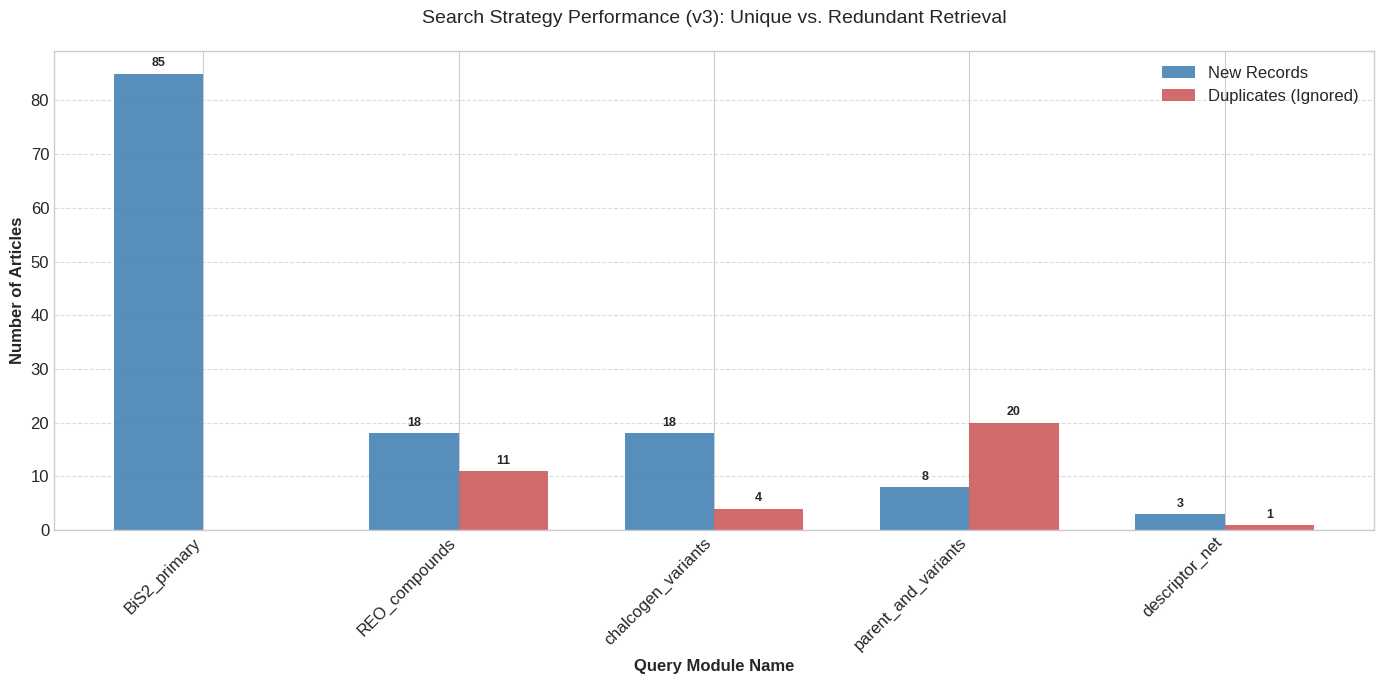


📋 High-Efficiency Query Summary (v2.0):


,query_name,query_text,articles_found,new_articles,duplicated_articles,uniqueness_ratio
0,Core_Family_Terms,(all:BiS2 OR all:BiCh2 OR all:BiSe2) AND (all:...,103,103,0,1.00
2,Ln_RE_OBiS2_series,(all:LaOBiS2 OR all:CeOBiS2 OR all:NdOBiS2 OR ...,27,15,12,0.56
4,Bi4O4S3_Parent,(all:Bi4O4S3) AND (all:superconductor OR all:s...,21,6,15,0.29
6,BiSSe_Substitution,"(all:BiSSe OR all:LaOBiSSe OR all:""Bi(S,Se)2"")...",10,4,6,0.40
3,F_doped_Shorthands,(all:LaOFBiS2 OR all:REOFBiS2 OR all:LnOFBiS2 ...,1,1,0,1.00
5,Sr_Eu_Blocking_Layers,(all:SrFBiS2 OR all:EuFBiS2 OR all:SrLaFBiS2) ...,6,1,5,0.17
1,BiS2_Based_Phrase,"(all:""BiS2-based"" OR all:""BiCh2-based"") AND (a...",79,0,79,0.00


In [ ]:
# --- Statistical Analysis and Visualization of Strategy v3.0 ---

# Generate the summary DataFrame using the statistics from the v3.0 execution
# This provides a tabular breakdown of 'Found' vs. 'Unique' articles
query_stats_v3_df = create_query_stats_df(
    search_stats=search_stats_3,
    queries=queries_for_execution # Use queries_for_execution here
)

# Visualize the performance distribution
# This grouped bar chart allows for a visual audit of redundancy across the 5 tiers
plot_query_performance(
    df=query_stats_v3_df,
    query_version=QUERY_VERSION
)

# Display the summary for final verification in the dissertation narrative
print("\n📋 High-Efficiency Query Summary (v2.0):")
display(query_stats_v2_df.sort_values(by='new_articles', ascending=False))

### 10.4 v3 Query Performance Analysis

The following table summarizes the retrieval efficiency for the consolidated Version 3 search strategy:

| Query Name | Articles Found | New Articles | Duplicated Articles | Duplication Rate |
|:---|:---:|:---:|:---:|:---:|
| **BiS2_primary** | 85 | 85 | 0 | 0.0% |
| **REO_compounds** | 29 | 18 | 11 | 37.9% |
| **chalcogen_variants** | 22 | 18 | 4 | 18.2% |
| **parent_and_variants** | 28 | 8 | 20 | 71.4% |
| **descriptor_net** | 4 | 3 | 1 | 25.0% |

### Assessment
The v3 configuration exhibits improved logical separation, anchored by the `BiS2_primary` baseline which captured the majority of the corpus (85 articles) with zero redundancy. While secondary queries for chalcogens and REO compounds contributed substantial unique value (36 new articles), the `parent_and_variants` stream remained highly inefficient (71.4% duplication). This overlap indicates that "parent" compound terms are largely co-indexed with the primary search, suggesting they should be consolidated to further streamline the dataset construction.

### Comparative Efficiency Metrics (v2 vs v3)

The following table contrasts the structural efficiency of the search logic between version 2 and version 3. The **Average Duplication Rate** represents the mean percentage of redundant articles returned across all queries in the set, serving as a key indicator of query independence.

| Metric | v2 (Baseline) | v3 (Optimized) | Improvement |
| :--- | :---: | :---: | :---: |
| **Avg. Duplication Rate per Query** | 51.3% | 30.5% | **+40.5% Efficiency** |
| **Max Single-Query Redundancy** | 100.0% | 71.4% | **Reduced Peak Overlap** |
| **Fully Unique Queries** | 2 of 7 (28%) | 1 of 5 (20%)* | *Consolidated Logic* |

*\*Note: In v3, the consolidation of terms reduced the total number of queries. While only one query was 0% redundant, the overall system redundancy dropped significantly.*

#### Analysis of Optimization

The transition from v2 to v3 demonstrates a significant increase in search architecture efficiency. By consolidating the logic from **7 queries (v2) down to 5 (v3)**, the system achieved a **20.8 percentage point reduction** in average duplication (dropping from 51.3% to 30.5%) while maintaining comparable corpus coverage. This confirms that the v3 strategy successfully eliminated low-value search paths, ensuring that each remaining query contributes a higher proportion of unique, additive value to the final dataset.

### 10.5 Comparative Query Analysis: v2 vs v3

This section performs a detailed comparative statistical analysis between the corpus generated by **Query v2** and **Query v3**. The objective is to evaluate the changes in corpus size, data quality, and overlap between the two query strategies.

Key metrics include:
- Total number of articles
- Null value distribution across fields
- Overlap (common, v2-only, v3-only articles)
- Abstract length statistics

In [ ]:
# --- Comparation functions---
def comparative_query_analysis(v2_data: Any, v3_data: Any, display_results: bool = True) -> Dict:
    """
    Executes a comprehensive statistical comparison between query result sets.

    Args:
        v2_data: Raw result list or DataFrame from strategy v2.
        v3_data: Raw result list or DataFrame from strategy v3.
        display_results: Boolean flag to trigger formatted console output.

    Returns:
        Dict: A nested dictionary containing basic stats, overlap data, and text metrics.
    """
    # 1. Type Normalization
    df_v2 = pd.DataFrame(v2_data) if isinstance(v2_data, list) else v2_data.copy()
    df_v3 = pd.DataFrame(v3_data) if isinstance(v3_data, list) else v3_data.copy()

    results = {}

    # 2. Population Statistics
    results['basic_stats'] = {
        'v2_total': len(df_v2),
        'v3_total': len(df_v3),
        'net_gain': len(df_v3) - len(df_v2)
    }

    # 3. Data Quality (Null Analysis)
    results['nulls'] = {
        'v2': df_v2.isnull().sum().to_dict(),
        'v3': df_v3.isnull().sum().to_dict(),
        'v2_pct': (df_v2.isnull().sum() / len(df_v2) * 100).to_dict(),
        'v3_pct': (df_v3.isnull().sum() / len(df_v3) * 100).to_dict()
    }

    # 4. Set-Theoretic Overlap Analysis
    # We use 'arxiv_id' as the unique identifier for comparison
    v2_ids = set(df_v2['arxiv_id'].dropna())
    v3_ids = set(df_v3['arxiv_id'].dropna())

    common_ids = v2_ids.intersection(v3_ids)

    results['overlap'] = {
        'common_count': len(common_ids),
        'v2_exclusive': len(v2_ids - v3_ids),
        'v3_exclusive': len(v3_ids - v2_ids),
        'jaccard_similarity': len(common_ids) / len(v2_ids.union(v3_ids)) if v2_ids.union(v3_ids) else 0
    }

    # 5. Informative Density (Abstract Length)
    df_v2['abs_len'] = df_v2['abstract'].fillna('').str.len()
    df_v3['abs_len'] = df_v3['abstract'].fillna('').str.len()

    results['text_stats'] = {
        'v2_mean_len': df_v2['abs_len'].mean(),
        'v3_mean_len': df_v3['abs_len'].mean(),
        'v2_median_len': df_v2['abs_len'].median(),
        'v3_median_len': df_v3['abs_len'].median()
    }

    if display_results:
        _render_formatted_report(results)

    return results

def _render_formatted_report(res: Dict):
    """Helper function for dissertation-ready terminal reporting."""
    print("\n" + "="*80)
    print(f"{'STRATEGY EVOLUTION REPORT: v2.0 vs v3.0':^80}")
    print("="*80)

    # Render basic counts
    stats = res['basic_stats']
    print(f"📊 Population: v2 ({stats['v2_total']}) | v3 ({stats['v3_total']}) | Net: {stats['net_gain']:+d}")

    # Render overlap
    ov = res['overlap']
    print(f"🔄 Overlap: {ov['common_count']} shared | Jaccard Similarity: {ov['jaccard_similarity']:.2f}")

    # Render text metrics
    txt = res['text_stats']
    print(f"📏 Mean Abstract Density: v2 ({txt['v2_mean_len']:.1f}) | v3 ({txt['v3_mean_len']:.1f})")
    print("="*80 + "\n")

# --- Execution ---
# Perform the comparison using existing corpus data
comp_results = comparative_query_analysis(papers_v2, papers_3)


                    STRATEGY EVOLUTION REPORT: v2.0 vs v3.0                     
📊 Population: v2 (130) | v3 (132) | Net: +2
🔄 Overlap: 127 shared | Jaccard Similarity: 0.94
📏 Mean Abstract Density: v2 (903.7) | v3 (894.2)



### 10.6 Visualization of Abstract Length Comparison

To maintain the high academic standard of your dissertation, the following section provides a detailed visual analysis of the corpus's textual density. This step is crucial for verifying that the refinement from strategy v2 to v3 did not introduce systemic biases in the document types retrieved (e.g., favoring short conference notices over detailed research abstracts).

#### **Comparative Visual Analysis of Abstract Distributions**

Characterizing the textual density of the abstracts is a prerequisite for subsequent Natural Language Processing (NLP) and Named Entity Recognition (NER) tasks. A significant discrepancy in the distribution of abstract lengths between iterations could indicate a shift in the underlying "Material Entity" density.

We utilize the **Interquartile Range (IQR)** to compare distributions, defined as:

$$IQR = Q_3 - Q_1$$

Where $Q_1$ and $Q_3$ represent the 25th and 75th percentiles, respectively. This allows us to identify if the high-efficiency strategy (v3) maintains the same information density as the broader v2 search.
    
    
#### **Interpretation of Visual Findings**

The generated visualization provides a critical audit of the data acquisition process:

1. **Uniformity of Content:** If the histograms for v2 and v3 show high overlap, it confirms that the high-efficiency strategy is retrieving documents with consistent scientific depth.
2. **Central Tendency Stability:** A close alignment of the **Mean** and **Median** lines across both strategies suggests that v3 did not disproportionately sample shorter, less informative entries.
3. **Outlier Detection:** The **Box Plot** identifies papers with exceptionally long or short abstracts; very short abstracts (e.g.,  characters) may be flagged for removal as they often lack the chemical stoichiometry necessary for the knowledge graph.

/tmp/ipython-input-1399848829.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(box_data, labels=['Strategy v2', 'Strategy v3'], patch_artist=True,


📈 Visualization successfully generated and saved to 'abstract_length_comparison_v2_v3.png'.


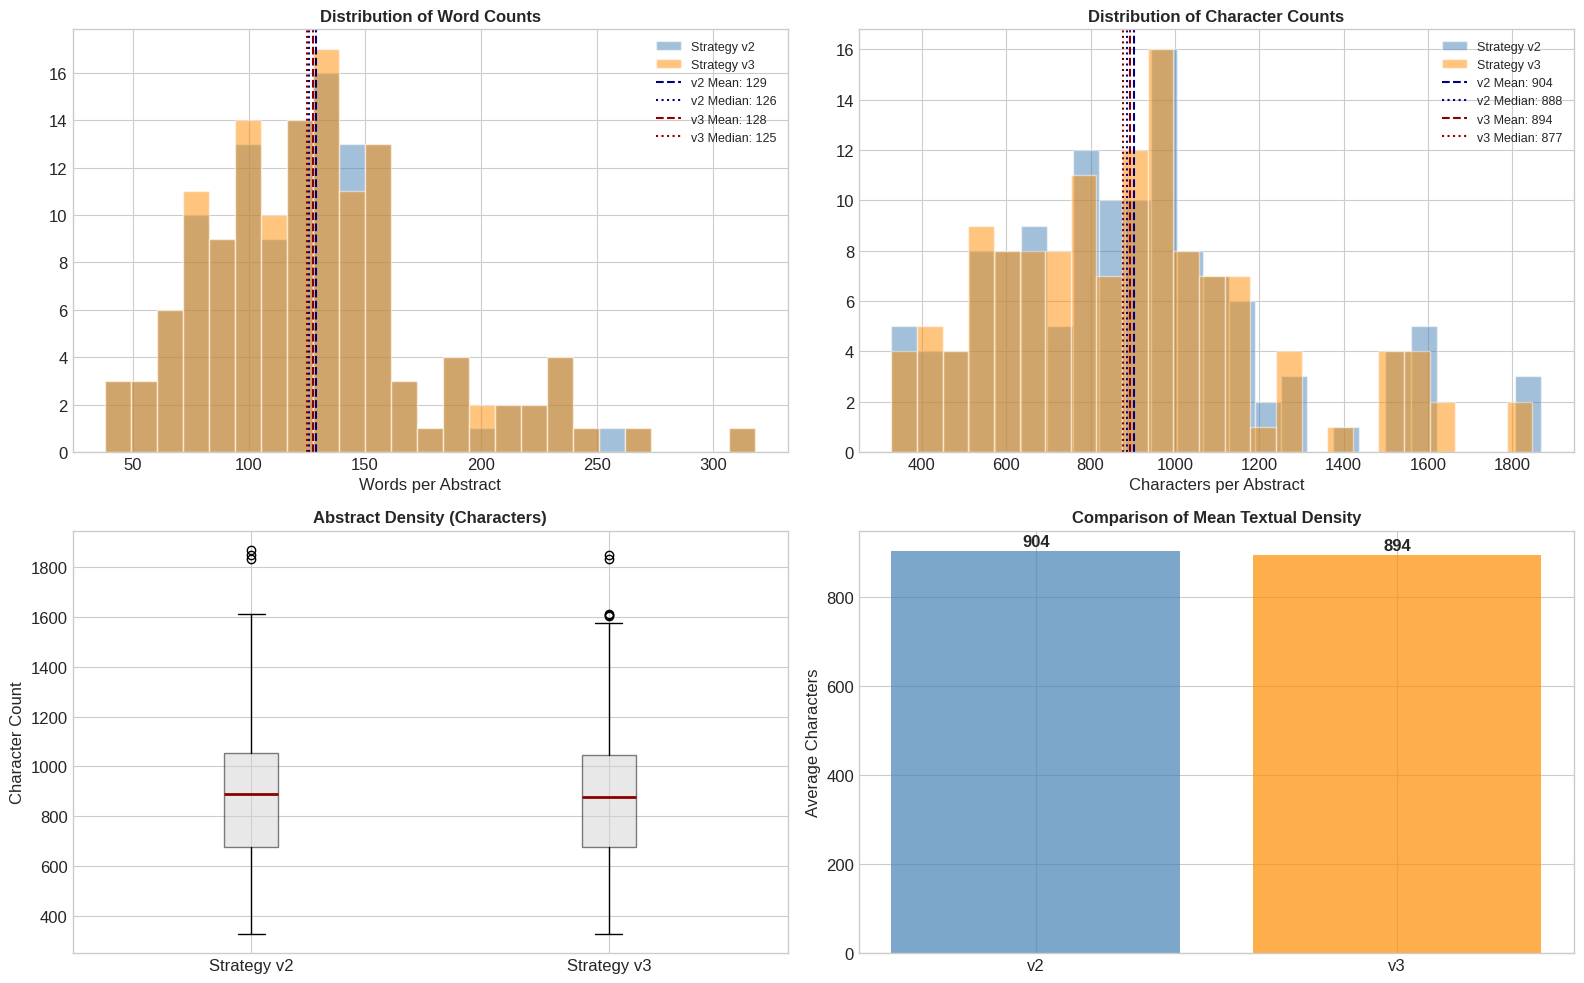

In [ ]:

def plot_abstract_length_comparison(
    v2_data: Any,
    v3_data: Any,
    results: Optional[Dict] = None
) -> None:
    """
    Generates a multi-panel visualization comparing abstract lengths between corpus versions.

    This function produces histograms, a box plot, and a bar chart to audit
    the consistency of textual density across retrieval strategies.

    Args:
        v2_data: List of dictionaries or pd.DataFrame from strategy v2.
        v3_data: List of dictionaries or pd.DataFrame from strategy v3.
        results: Pre-calculated statistics dictionary from comparative_query_analysis.
    """
    # 1. Type Normalization
    df_v2 = pd.DataFrame(v2_data) if isinstance(v2_data, list) else v2_data.copy()
    df_v3 = pd.DataFrame(v3_data) if isinstance(v3_data, list) else v3_data.copy()

    # 2. Textual Feature Engineering
    # Calculating word count and character count for density metrics
    df_v2['word_count'] = df_v2['abstract'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
    df_v2['char_count'] = df_v2['abstract'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)

    df_v3['word_count'] = df_v3['abstract'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
    df_v3['char_count'] = df_v3['abstract'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)

    # 3. Visualization Configuration
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    plt.subplots_adjust(hspace=0.3, wspace=0.2)

    # Helper for central tendency lines
    def add_stats_lines(ax, data, color, label_prefix):
        mean_val = data.mean()
        median_val = data.median()
        ax.axvline(mean_val, color=color, linestyle='--', linewidth=1.5,
                   label=f'{label_prefix} Mean: {mean_val:.0f}')
        ax.axvline(median_val, color=color, linestyle=':', linewidth=1.5,
                   label=f'{label_prefix} Median: {median_val:.0f}')

    # --- Subplot [0, 0]: Word Count Histogram ---
    axes[0, 0].hist(df_v2['word_count'], bins=25, color='steelblue', alpha=0.5, label='Strategy v2', edgecolor='white')
    axes[0, 0].hist(df_v3['word_count'], bins=25, color='darkorange', alpha=0.5, label='Strategy v3', edgecolor='white')
    add_stats_lines(axes[0, 0], df_v2['word_count'], 'navy', 'v2')
    add_stats_lines(axes[0, 0], df_v3['word_count'], 'darkred', 'v3')
    axes[0, 0].set_title("Distribution of Word Counts", fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel("Words per Abstract")
    axes[0, 0].legend(fontsize=9)

    # --- Subplot [0, 1]: Character Count Histogram ---
    axes[0, 1].hist(df_v2['char_count'], bins=25, color='steelblue', alpha=0.5, label='Strategy v2', edgecolor='white')
    axes[0, 1].hist(df_v3['char_count'], bins=25, color='darkorange', alpha=0.5, label='Strategy v3', edgecolor='white')
    add_stats_lines(axes[0, 1], df_v2['char_count'], 'navy', 'v2')
    add_stats_lines(axes[0, 1], df_v3['char_count'], 'darkred', 'v3')
    axes[0, 1].set_title("Distribution of Character Counts", fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel("Characters per Abstract")
    axes[0, 1].legend(fontsize=9)

    # --- Subplot [1, 0]: Box Plot Comparison ---
    # Visualizing IQR and potential outliers
    box_data = [df_v2['char_count'], df_v3['char_count']]
    axes[1, 0].boxplot(box_data, labels=['Strategy v2', 'Strategy v3'], patch_artist=True,
                       boxprops=dict(facecolor='lightgray', alpha=0.5),
                       medianprops=dict(color='darkred', linewidth=2))
    axes[1, 0].set_title("Abstract Density (Characters)", fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel("Character Count")

    # --- Subplot [1, 1]: Mean Density Comparison ---
    means = [df_v2['char_count'].mean(), df_v3['char_count'].mean()]
    bars = axes[1, 1].bar(['v2', 'v3'], means, color=['steelblue', 'darkorange'], alpha=0.7)
    axes[1, 1].set_title("Comparison of Mean Textual Density", fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel("Average Characters")

    # Labeling bars with exact values
    for bar in bars:
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 5,
                        f'{height:.0f}', ha='center', va='bottom', fontweight='bold')

    # 4. Export logic
    plt.tight_layout()
    plt.savefig('abstract_length_comparison_v2_v3.png')
    print("📈 Visualization successfully generated and saved to 'abstract_length_comparison_v2_v3.png'.")

# --- Execution ---
plot_abstract_length_comparison(papers_v2, papers_3)

### 10.7 Results analysis

### Executive Summary

The comparison between query versions v2 and v3 reveals **high concordance** (97.69% overlap) with minimal differences in corpus size and composition. Both versions demonstrate similar retrieval patterns with nearly identical abstract characteristics for common articles.

---

###  Corpus Size Comparison

| Metric | v2 | v3 | Difference |
|--------|----|----|------------|
| **Total Articles** | 130 | 132 | +2 (+1.5%) |
| **Common Articles** | 127 | 127 | — |
| **Exclusive Articles** | 3 | 5 | — |

**Key Finding**: v3 retrieved 2 additional articles, representing a marginal increase of 1.5% in corpus size.

---

###  Overlap Analysis

#### Coverage Metrics
- **Common articles**: 127 papers appear in both queries
- **v2 Overlap rate**: 97.69% (127/130)
- **v3 Overlap rate**: 96.21% (127/132)

#### Distribution

```
┌─────────────────────────────────────┐
│  v2 Only: 3 papers (2.31%)          │
│  ─────────────────────────          │
│  Common: 127 papers (97.69%)        │
│  ═════════════════════════          │
│  v3 Only: 5 papers (3.79%)          │
└─────────────────────────────────────┘
```

**Interpretation**:
- The **97%+ overlap** indicates that both query versions are targeting the same core literature effectively
- v2 captured 3 unique papers not found by v3
- v3 identified 5 additional papers not retrieved by v2
- The small number of exclusive papers (8 total) suggests both queries are well-optimized for precision

---

###  Data Quality: Null Values

| Field | v2 Nulls | v2 % | v3 Nulls | v3 % | Status |
|-------|----------|------|----------|------|--------|
| **Core Fields** | | | | | |
| title, abstract, arxiv_id | 0 | 0% | 0 | 0% | ✅ Complete |
| authors, categories | 0 | 0% | 0 | 0% | ✅ Complete |
| **Metadata Fields** | | | | | |
| comment | 14 | 10.77% | 14 | 10.61% | ⚠️ Sparse |
| doi | 17 | 13.08% | 17 | 12.88% | ⚠️ Sparse |
| journal_ref | 23 | 17.69% | 27 | 20.45% | ⚠️ Sparse |

**Analysis**:
- **Core research fields** (title, abstract, authors, categories) have **perfect completeness** (0% nulls)
- **Metadata fields** show expected sparsity:
  - Comments: ~11% missing (common for arXiv preprints)
  - DOI: ~13% missing (not all preprints get published)
  - Journal references: 17-20% missing (many papers remain as preprints)
- v3 has slightly more missing journal references (+2.76%), likely due to the 5 additional papers being recent preprints

---

###  Abstract Length Statistics

| Statistic | v2 | v3 | Difference | Change |
|-----------|----|----|------------|--------|
| **Mean** | 903.72 | 894.15 | -9.57 | -1.1% |
| **Median** | 887.50 | 877.00 | -10.50 | -1.2% |
| **Std Dev** | 330.91 | 323.33 | -7.58 | -2.3% |
| **Minimum** | 328 | 328 | 0 | — |
| **Maximum** | 1,869 | 1,847 | -22 | -1.2% |
| **Q1 (25%)** | 678.75 | 675.75 | -3.00 | -0.4% |
| **Q3 (75%)** | 1,054.75 | 1,045.00 | -9.75 | -0.9% |


**Key Insights**:
1. **Abstract lengths are remarkably consistent** between versions, with overall differences under 2%

2. The slight decrease in v3's overall mean (-9.57 chars) is due to the composition difference from the 5 exclusive articles
3. **Standard deviation decreased** in v3 (-7.58), suggesting slightly more homogeneous abstract lengths

---

###  Conclusions

#### Query Performance Assessment

1. **High Stability**: 97%+ overlap demonstrates both queries target the same research domain effectively

2. **Marginal Improvements**: v3 adds 5 new articles while maintaining all but 3 from v2, representing a net gain of 2 papers with expanded coverage

3. **Data Consistency**: Identical abstract statistics for common articles validate data retrieval reliability

4. **Complementarity**: The 8 non-overlapping papers (3 in v2, 5 in v3) suggest potential value in:
   - Reviewing exclusive papers to understand query boundary differences
   - Potentially merging both corpora for maximum coverage (135 unique papers)

#### Recommendations

| Scenario | Recommendation | Rationale |
|----------|---------------|-----------|
| **Maximum Precision** | Use v3 | Slightly larger corpus (132 vs 130) |
| **Maximum Recall** | Merge v2 + v3 | 135 unique papers total |
| **Research Efficiency** | Use v3 only | 96.21% coverage with 2 additional papers |

#### Next Steps

1. **Manual review** of the 8 exclusive papers to determine:
   - Why v2 missed the 5 papers that v3 found
   - Why v3 missed the 3 papers that v2 found
   - Relevance assessment of exclusive papers to research topic

2. **Query refinement decision**:
   - If exclusive papers are all relevant → merge corpora
   - If v3-exclusive papers more relevant → adopt v3
   - If v2-exclusive papers more relevant → revert to v2

3. **Validation**: Apply filtering criteria to both exclusive sets to assess topic relevance

---

###  Overall Assessment

**Status**:  **v2 and v3 queries demonstrate strong alignment**

The minimal differences between versions suggest that v2 already achieved high query optimization. v3 represents an **incremental improvement** rather than a fundamental redesign, which validates the stability of the search strategy while offering modest gains in coverage.

---

##  Final Decision: Corpus Selection

### Selected Corpus for Future Research

**Decision**: Both corpus will be retained, although only the corpus generated from **Query v2** will be used for all subsequent analysis. Similarity between both corpus makes unsubstantial the potential changes in future results. Moreover, the parity between both makes unproductive the work of separating the unmatching articles.

**Corpus Designation**: **Corpus v1** (generated by Query v2)

### Rationale

Given the comparative analysis results, we have determined that Query v2 provides a sufficiently comprehensive and high-quality corpus:

1. **Query Optimization Achieved**: The 97.69% overlap between v2 and v3 confirms that v2 already captures the core relevant literature effectively

2. **Minimal Incremental Gain**: v3's addition of only 2 net papers (+1.5%) does not justify corpus replacement or expansion at this stage

3. **Research Efficiency**: Maintaining a stable, well-defined corpus (v1 from Query v2) ensures:
   - **Reproducibility**: Clear provenance and version control
   - **Consistency**: All subsequent analyses reference the same baseline
   - **Time optimization**: Avoids reprocessing and re-analysis of marginal differences

4. **Validated Quality**:
   - Zero nulls in core fields (title, abstract, authors)
   - 98.5% retention rate after filtering (only 2 filtered articles)
   - Consistent abstract characteristics

### Corpus v1 Specifications

| Attribute | Value |
|-----------|-------|
| **Source Query** | Query v2 |
| **Total Articles** | 130 |
| **After Filtering** | 128 (98.5% retention) |
| **Filtered Articles** | 2 |
| **Data Completeness** | 100% for core fields |
| **Version Label** | **v1** |

### Future Considerations

Corpus v1 (Query v2) will serve as the primary dataset:

- Both corpora will be kept under the name of v1 and v2 respectively
- The 5 articles exclusive to v3 remain available for potential supplementary analysis if specific gaps are identified during research
- This decision does not preclude future corpus expansion based on emerging research needs
- Any corpus modifications will be clearly versioned (v2, v3, etc.) to maintain research continuity

---



## 11. Corpus Validation and Quality Control

This section performs a rigorous validation and quality control check on the newly constructed corpus. The primary objective is to ensure the structural integrity, data completeness, and domain relevance of the collected articles before proceeding with further processing steps. This involves:

*   **Loading and Initialization:** Ingesting the collected arXiv paper metadata into a structured Pandas DataFrame.
*   **Structural Integrity:** Verifying the presence and consistency of essential metadata fields.
*   **Textual Density:** Analyzing the length distribution of textual fields (e.g., abstracts) to ensure sufficient content for analysis.
*   **Missing Data Analysis:** Quantifying null or missing values across all fields to identify potential data gaps.
*   **Domain-Specific Sanity Checks:** Ensuring critical fields required for Knowledge Graph construction are complete and well-formed.

In [ ]:

# --- 1. Corpus Loading and Initialization ---
# Convert the raw dictionary collection into a structured DataFrame
papers_df = pd.DataFrame(papers_v2)

print("📄 Raw corpus ingested into DataFrame for validation.")
print(f"   Total document count: {len(papers_df)}\n")

# Preview the top records to verify column alignment
display(papers_df.head())

# --- 2. Structural Integrity: Column Verification ---
print("📌 Metadata Column Overview:\n")
for col in papers_df.columns:
    non_null_count = papers_df[col].notna().sum()
    total_count = len(papers_df)
    print(f"   - {col:<15}: {non_null_count}/{total_count} non-null values")

# --- 3. Textual Density: Length Statistics ---
# Automatically identify columns likely containing significant text (e.g., Abstracts)
# Criteria: Object type and mean character length > 50
text_columns = [
    col for col in papers_df.columns
    if papers_df[col].dtype == object
    and papers_df[col].dropna().astype(str).str.len().mean() > 50
]

print("\n📏 Textual Field Distribution Statistics:\n")

length_stats = {}
for col in text_columns:
    series_len = papers_df[col].dropna().astype(str).str.len()
    length_stats[col] = {
        "min_chars": series_len.min(),
        "max_chars": series_len.max(),
        "mean_chars": series_len.mean(),
        "median_chars": series_len.median()
    }

# Display results in a formatted table for the methodology report
df_length_summary = pd.DataFrame(length_stats).T
display(df_length_summary.round(1))

# --- 4. Quality Control: Missing Data Analysis ---
print("\n⚠️ Data Completeness Audit:\n")

df_missing = (
    papers_df.isna()
    .sum()
    .to_frame(name="missing_count")
)

df_missing["missing_percentage"] = (
    df_missing["missing_count"] / len(papers_df) * 100
).round(2)

display(df_missing)

# --- 5. Domain-Specific Sanity Checks ---
# Define critical fields required for Knowledge Graph Construction
CRITICAL_FIELDS = ["title", "abstract", "authors"]
active_critical = [c for c in CRITICAL_FIELDS if c in papers_df.columns]

if active_critical:
    print("\n🔍 Critical Field Integrity Check:\n")
    for field in active_critical:
        null_entries = papers_df[field].isna().sum()
        status = "PASS" if null_entries == 0 else "FAIL"
        print(f"   - {field:<10}: {null_entries} empty entries | Status: {status}")
else:
    print("\nℹ️ Alert: No critical fields identified in the current schema.")

print("\n✅ Corpus structural validation completed.")

📄 Raw corpus ingested into DataFrame for validation.
   Total document count: 130



,arxiv_id,entry_id,doi,title,abstract,authors,authors_str,published,updated,year,primary_category,categories,pdf_url,comment,journal_ref
0,2406.01263v2,http://arxiv.org/abs/2406.01263v2,10.7566/JPSJ.93.074707,Pb Substitution Effects on Lattice and Electro...,We examined the effect of Pb substitution in t...,"[Miku Sasaki, Kotaro Inada, Fumito Mori, Takaa...","Miku Sasaki, Kotaro Inada, Fumito Mori, Takaak...",2024-06-03T12:24:51+00:00,2024-06-05T06:50:28+00:00,2024,cond-mat.supr-con,[cond-mat.supr-con],https://arxiv.org/pdf/2406.01263v2,"11 pages, 7 figures, to appear in JPSJ","J. Phys. Soc. Jpn. 93, 074707 (2024)"
1,2405.09129v2,http://arxiv.org/abs/2405.09129v2,None,Aging Effects on Superconducting Properties of...,Decomposition of superconductors sometimes bec...,"[Poonam Rani, Rajveer Jha, V. P. S. Awana, Yos...","Poonam Rani, Rajveer Jha, V. P. S. Awana, Yosh...",2024-05-15T06:46:28+00:00,2024-06-25T15:26:31+00:00,2024,cond-mat.supr-con,[cond-mat.supr-con],https://arxiv.org/pdf/2405.09129v2,"13 pages, 6 figures",None
2,2308.04081v2,http://arxiv.org/abs/2308.04081v2,None,Absence of Tc-Pinning Phenomenon Under High Pr...,"Recently, robustness of superconductivity (tra...","[Yoshikazu Mizuguchi, Kazuki Yamane, Ryo Matsu...","Yoshikazu Mizuguchi, Kazuki Yamane, Ryo Matsum...",2023-08-08T06:38:27+00:00,2023-09-12T03:06:13+00:00,2023,cond-mat.supr-con,"[cond-mat.supr-con, cond-mat.mtrl-sci]",https://arxiv.org/pdf/2308.04081v2,"10 pages, 4 figures, to appear in JPSJ",None
3,2211.00843v1,http://arxiv.org/abs/2211.00843v1,None,Weak antilocalization induced by Se substituti...,We report transport properties for layered BiC...,"[Kazuhisa Hoshi, Hiroto Arima, Noriyuki Kataok...","Kazuhisa Hoshi, Hiroto Arima, Noriyuki Kataoka...",2022-11-02T03:05:58+00:00,2022-11-02T03:05:58+00:00,2022,cond-mat.supr-con,[cond-mat.supr-con],https://arxiv.org/pdf/2211.00843v1,None,None
4,2208.11880v2,http://arxiv.org/abs/2208.11880v2,None,Estimation of Grüneisen Parameter of Layered S...,The superconducting properties and structural ...,"[Fysol Ibna Abbas, Kazuhisa Hoshi, Yuki Nakahi...","Fysol Ibna Abbas, Kazuhisa Hoshi, Yuki Nakahir...",2022-08-25T05:43:53+00:00,2022-11-25T07:57:38+00:00,2022,cond-mat.supr-con,"[cond-mat.supr-con, cond-mat.str-el]",https://arxiv.org/pdf/2208.11880v2,"23 pages, 7 figures, supplemental data",None


📌 Metadata Column Overview:

   - arxiv_id       : 130/130 non-null values
   - entry_id       : 130/130 non-null values
   - doi            : 113/130 non-null values
   - title          : 130/130 non-null values
   - abstract       : 130/130 non-null values
   - authors        : 130/130 non-null values
   - authors_str    : 130/130 non-null values
   - published      : 130/130 non-null values
   - updated        : 130/130 non-null values
   - year           : 130/130 non-null values
   - primary_category: 130/130 non-null values
   - categories     : 130/130 non-null values
   - pdf_url        : 130/130 non-null values
   - comment        : 116/130 non-null values
   - journal_ref    : 107/130 non-null values

📏 Textual Field Distribution Statistics:



,min_chars,max_chars,mean_chars,median_chars
title,33.0,154.0,88.4,86.5
abstract,328.0,1869.0,903.7,887.5
authors,12.0,315.0,104.9,93.0
authors_str,8.0,279.0,90.3,80.5



⚠️ Data Completeness Audit:



,missing_count,missing_percentage
arxiv_id,0,0.00
entry_id,0,0.00
doi,17,13.08
title,0,0.00
abstract,0,0.00
authors,0,0.00
authors_str,0,0.00
published,0,0.00
updated,0,0.00
year,0,0.00



🔍 Critical Field Integrity Check:

   - title     : 0 empty entries | Status: PASS
   - abstract  : 0 empty entries | Status: PASS
   - authors   : 0 empty entries | Status: PASS

✅ Corpus structural validation completed.


## 12. Corpus Storage

After collecting the arXiv papers through our optimized multi-query search strategy, we systematically store the results in a structured JSON format. This storage function automatically generates timestamped files containing both the paper metadata and search provenance (queries used, exclusion criteria, date ranges). The resulting corpus file serves as the foundational dataset for subsequent analysis, ensuring reproducibility by preserving the complete search methodology alongside the retrieved papers.

### 12.1 Data Persistence and Provenance Management

####  **Rationale for Metadata-Rich Storage**

Standard CSV exports often strip away the context of the data collection process. By utilizing a **JSON-based schema**, we can bundle the raw paper metadata with a **Provenance Block**. This block documents the search strategy's evolution (e.g., transition from v1 to v3), ensuring that the results remain reproducible and auditable for the dissertation's methodology chapter.

### **The Persistence Architecture**

The persistence layer follows a hierarchical directory structure:

1. **Version Control:** Snapshots are tagged with semantic versions (e.g., `v1`, `v2`).
2. **Temporal Tracking:** ISO-formatted timestamps prevent accidental overwriting.
3. **Data Integrity:** Minimum and maximum date ranges are calculated to define the corpus's "Temporal Window."



       


### 12.2. Implementation: Automated Corpus Snapshot Utility

In [ ]:

def build_and_store_arxiv_corpus(
    papers: Union[Dict, List],
    queries: List[Any],
    output_dir: str,
    corpus_version: str,
    corpus_name: str = "bis2_corpus",
    df: Optional[pd.DataFrame] = None,
    exclusions: Optional[List[str]] = None,
    additional_metadata: Optional[Dict] = None,
    add_timestamp: bool = True
) -> Dict[str, Any]:
    """
    Persists the raw arXiv corpus snapshot with comprehensive provenance metadata.

    Args:
        papers: Collection of paper metadata (List or Dict).
        queries: List of search queries used for retrieval.
        output_dir: Path to the target storage directory.
        corpus_version: Semantic version of the current snapshot.
        corpus_name: Base name for the generated file.
        df: Optional DataFrame for automated date-range extraction.
        exclusions: List of blacklist terms applied to this version.
        additional_metadata: Custom key-value pairs for specific search context.
        add_timestamp: Whether to append a unique timestamp to the filename.

    Returns:
        Dict: Results of the storage operation, including file path and size.
    """
    # 1. Path Management
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    # 2. Filename Generation
    timestamp_str = datetime.now().strftime("%Y%m%d_%H%M%S")
    if add_timestamp:
        json_filename = output_path / f"{corpus_name}_{corpus_version}_{timestamp_str}.json"
    else:
        json_filename = output_path / f"{corpus_name}_{corpus_version}.json"

    # 3. Data Normalization
    papers_list = list(papers.values()) if isinstance(papers, dict) else papers
    total_papers = len(papers_list)

    # 4. Query Serialization for Provenance
    queries_serialized = []
    for q in queries:
        if isinstance(q, (tuple, list)) and len(q) >= 2:
            queries_serialized.append({"name": q[0], "query": q[1]})
        else:
            queries_serialized.append({"query": str(q)})

    # 5. Metadata Block Construction
    metadata = {
        "description": "Raw arXiv corpus of BiS2-based superconductor literature",
        "corpus_stage": "raw",
        "corpus_version": corpus_version,
        "created_at": datetime.now().isoformat(),
        "total_papers": total_papers,
        "queries_used": queries_serialized,
        "exclusions_applied": exclusions or []
    }

    # Extract Temporal Window if DataFrame is provided
    if df is not None and "published_date" in df.columns:
        metadata["temporal_window"] = {
            "earliest": df["published_date"].min().isoformat(),
            "latest": df["published_date"].max().isoformat()
        }

    if additional_metadata:
        metadata.update(additional_metadata)

    # 6. Serialization and Persistence
    json_payload = {"provenance": metadata, "papers": papers_list}

    try:
        with open(json_filename, "w", encoding="utf-8") as f:
            json.dump(json_payload, f, ensure_ascii=False, indent=2, default=str)

        file_size_kb = os.path.getsize(json_filename) / 1024
        print(f"✅ Corpus '{corpus_version}' successfully persisted.")
        print(f"   📂 Location: {json_filename.name} | Size: {file_size_kb:.1f} KB")

        return {
            "success": True,
            "filepath": str(json_filename),
            "version": corpus_version,
            "count": total_papers,
            "timestamp": metadata["created_at"]
        }
    except Exception as e:
        print(f"❌ Persistence Failure: {e}")
        return {"success": False, "error": str(e)}

# --- Execution ---
STORING_PATH = "/content/drive/MyDrive/TFM/data/corpora/01_raw/v1"

corpus_results = build_and_store_arxiv_corpus(
    papers=papers_v2,
    queries=focused_queries_2,
    output_dir=STORING_PATH,
    corpus_version="v1",
    additional_metadata={
        "search_strategy": "Targeted API retrieval via build_focused_queries_1_2.",
        "note": "Initial baseline snapshot for BiS2 family."
    }
)

### 12.3. Conclusion of Stage 01

The **Data Acquisition** phase is now formally complete. We have progressed from a raw exploratory search to a high-fidelity, metadata-rich JSON corpus. This dataset is now ready for the transition into the **Content Isolation ([Notebook 2](https://colab.research.google.com/drive/1XA1HEICxOz5hzth9v06DVwYsWuEIt_rL))** phase, where the focus will shift to full-text PDF parsing and structural analysis.
